# TReNDS - Tabular NN 0.159

LB: 0.159

## Credits
Many ideas of my notebook are derived from this [notebook](https://www.kaggle.com/iafoss/grapheme-fast-ai-starter-lb-0-964#MixUp) from the Bengaliai competition earlier this year. Please go there and upvote if you find this or other references usefull.
Here are the references in detail:
- https://www.kaggle.com/iafoss/grapheme-fast-ai-starter-lb-0-964#MixUp: Multi head - metrics, - loss function

- Schaefer 2018 -features: https://www.kaggle.com/kpriyanshu256/trends-image-features-1000/output
- Analysis of optimal Cluster Size: https://www.kaggle.com/mks2192/trends-cluster-sfnc-groups
- Using Schaefer 2018-features as time series: https://www.kaggle.com/kpriyanshu256/trends-time-series

In [1]:
import numpy as np
import pandas as pd

from pathlib import Path
from matplotlib import pyplot as plt
import seaborn as sns

from sklearn.model_selection import KFold, StratifiedKFold

from fastai.tabular import * 
from fastai import *

import os, shutil
import sys

In [2]:
#https://www.kaggle.com/c/jigsaw-multilingual-toxic-comment-classification/discussion/150697#845512
import logging
logging.getLogger().setLevel(logging.NOTSET)
# Notebook Settings

# np.set_printoptions(threshold=sys.maxsize)

In [3]:
kaggle_path = Path('.')
kaggle_input_path = Path('/kaggle/input/trends-assessment-prediction') # '/kaggle/input/trends-assessment-prediction'
cluster_input_path = Path('/kaggle/input/trends-cluster-sfnc-groups')
av_input_path = Path('/kaggle/input/trends-av-probs-of-test-and-s2')
img_53000_path = Path('/kaggle/input/fork-of-trends-image-features-53-100')

#https://www.kaggle.com/mks2192/trends-cluster-sfnc-groups/output
#for dirname, _, filenames in os.walk(kaggle_input_path):
#    print(dirname)#, filenames)

# Parameters

In [4]:
INCLUDE_FNC_DATA = True

INCLUDE_FNC_CLUSTERS = False
INCLUDE_FNC_DIST_CCENTER = False

INCLUDE_FNC_CLUSTERS_2 = True
INCLUDE_FNC_DIST_CCENTER_2 = True

INCLUDE_IMG_53000 = False

INCLUDE_AV_DATA = False

IMPUTATION_STRAT = 'IGNORE_ON_TRAIN' # 'IGNORE_ON_TRAIN', 'MEAN' 
#LOSS_BASE = 'MIX' #'MSE' # 'MSE' # 'L1' 'MIX'
LOSS_WEIGHTS = [0.3, 0.175, 0.175, 0.175, 0.175] #[0.2,0.2,0.2,0.2,0.2] #[0,0,0,0,1]#
BS = 128

DEP_VAR = ['age','domain1_var1','domain1_var2', 'domain2_var1', 'domain2_var2']

# Prepare data

Including all tabular data but IC_20 (removing or adding IC_20 doesn't influence the public LB).

In [5]:
l_data = pd.read_csv(kaggle_input_path/'loading.csv').drop('IC_20',axis=1)

if INCLUDE_FNC_DATA:
    f_data = pd.read_csv(kaggle_input_path/'fnc.csv')
    l_data = l_data.merge(f_data, on='Id', how = 'inner')

if INCLUDE_FNC_CLUSTERS:
    c_data = pd.read_csv(cluster_input_path/'sfnc_group_clusters.csv')
    l_data = l_data.merge(c_data, on='Id', how = 'inner')

if INCLUDE_FNC_DIST_CCENTER:
    cc_data = pd.read_csv(cluster_input_path/'sfnc_dist_to_cluster_center.csv')
    l_data = l_data.merge(cc_data, on='Id', how = 'inner')
    

if INCLUDE_FNC_CLUSTERS_2:
    c2_data = pd.read_csv(cluster_input_path/'sfnc_group_clusters_2c.csv')
    temp_col = []
    for c in c2_data.columns:
        if c != 'Id':
            temp_col += [c+'_2']
        else:
            temp_col += [c]
    c2_data.columns = temp_col
    l_data = l_data.merge(c2_data, on='Id', how = 'inner')

if INCLUDE_FNC_DIST_CCENTER_2:
    cc2_data = pd.read_csv(cluster_input_path/'sfnc_dist_to_cluster_center_2c.csv')
    temp_col = []
    for c in cc2_data.columns:
        if c != 'Id':
            temp_col += [c+'_2']
        else:
            temp_col += [c]
    cc2_data.columns = temp_col
    l_data = l_data.merge(cc2_data, on='Id', how = 'inner')
    

if INCLUDE_IMG_53000:
    i_data = pd.read_csv(img_53000_path/'train_features.csv')
    i_data = i_data.append(pd.read_csv(img_53000_path/'test_features.csv'))
    l_data = l_data.merge(i_data, on='Id', how = 'inner')

    
if INCLUDE_AV_DATA:
    av_data = pd.read_csv(av_input_path/'test_s2_probs.csv')
    l_data = l_data.merge(av_data, on='Id', how = 'inner')



y_data = pd.read_csv(kaggle_input_path/'train_scores.csv')

idx_site2 = pd.read_csv(kaggle_input_path/'reveal_ID_site2.csv')
#submission = pd.read_csv(kaggle_input_path/'sample_submission.csv')

In [6]:
#i_data.info()

In [7]:
display(y_data.head())
display(y_data.describe())
y_data.shape

,Id,age,domain1_var1,domain1_var2,domain2_var1,domain2_var2
0,10001,57.436077,30.571975,62.553736,53.325130,51.427998
1,10002,59.580851,50.969456,67.470628,60.651856,58.311361
2,10004,71.413018,53.152498,58.012103,52.418389,62.536641
3,10005,66.532630,NaN,NaN,52.108977,69.993075
4,10007,38.617381,49.197021,65.674285,40.151376,34.096421


,Id,age,domain1_var1,domain1_var2,domain2_var1,domain2_var2
count,5877.000000,5877.000000,5439.000000,5439.000000,5838.000000,5838.000000
mean,15909.667007,50.034068,51.474692,59.244132,47.325130,51.905658
std,3411.775315,13.539881,10.188354,11.387595,11.124863,11.839203
min,10001.000000,14.257265,15.769168,1.021874,0.991172,0.815285
25%,12961.000000,40.129361,44.781240,52.396805,40.122682,44.514880
50%,15925.000000,50.427747,51.847306,60.052535,47.811205,52.572032
75%,18886.000000,59.580851,58.495576,67.142611,55.058014,59.910146
max,21754.000000,84.491113,81.325580,94.702874,82.164478,94.509903


(5877, 6)

In [8]:
display(l_data.tail())
display(l_data.describe()),
l_data.shape

,Id,IC_01,IC_07,IC_05,IC_16,IC_26,IC_06,IC_10,IC_09,IC_18,...,DMN_CON_c0_2,DMN_CON_c1_2,CBN_CON_c0_2,CBN_CON_c1_2,DMN_DMN_c0_2,DMN_DMN_c1_2,CBN_DMN_c0_2,CBN_DMN_c1_2,CBN_CBN_c0_2,CBN_CBN_c1_2
11749,21750,0.005996,0.003873,0.012353,0.000242,-0.002159,0.020201,0.020931,0.003684,-0.002458,...,1.428076,1.708717,1.174876,1.414423,0.654067,1.022526,0.695594,1.178962,0.442778,0.269252
11750,21751,0.003835,0.015067,0.015428,-0.002030,0.001205,0.012396,0.011026,-0.001491,0.005310,...,2.722291,2.346500,2.476566,2.905256,0.929018,0.863913,1.520354,1.580052,0.635350,0.214796
11751,21752,0.000627,0.011407,0.010957,0.000534,-0.000347,0.013499,0.010541,0.001867,0.007447,...,1.915513,1.754705,1.599203,1.349152,0.569436,0.822079,0.604629,0.783760,0.330336,0.372306
11752,21753,0.007431,0.021419,0.014143,-0.005623,-0.006399,0.008602,0.006831,-0.001018,0.014972,...,2.373179,2.061757,1.431874,1.882552,0.723917,1.089846,1.037346,0.864490,0.469622,0.642797
11753,21754,0.010670,0.010670,0.006662,-0.002215,-0.001773,0.006544,0.010900,0.000563,0.002995,...,1.988651,1.954655,1.551754,1.731246,0.763838,1.318825,1.156840,1.176118,0.354882,0.467494


,Id,IC_01,IC_07,IC_05,IC_16,IC_26,IC_06,IC_10,IC_09,IC_18,...,DMN_CON_c0_2,DMN_CON_c1_2,CBN_CON_c0_2,CBN_CON_c1_2,DMN_DMN_c0_2,DMN_DMN_c1_2,CBN_DMN_c0_2,CBN_DMN_c1_2,CBN_CBN_c0_2,CBN_CBN_c1_2
count,11754.000000,11754.000000,11754.000000,11754.000000,11754.000000,11754.000000,11754.000000,11754.000000,11754.000000,11754.000000,...,11754.000000,11754.000000,11754.000000,11754.000000,11754.000000,11754.000000,11754.000000,11754.000000,11754.000000,11754.000000
mean,15877.500000,0.005423,0.009251,0.010635,0.001054,-0.001271,0.013410,0.013749,0.001988,0.005053,...,2.030642,2.016219,1.499319,1.655957,0.840603,0.845362,0.965971,1.025109,0.465783,0.535961
std,3393.231867,0.004552,0.004153,0.003609,0.003591,0.002658,0.004032,0.003905,0.003200,0.005296,...,0.340441,0.377040,0.392934,0.355182,0.233000,0.259065,0.298486,0.265286,0.234644,0.253420
min,10001.000000,-0.015894,-0.015927,-0.002240,-0.013459,-0.015118,-0.002929,0.001156,-0.009622,-0.027575,...,1.091840,1.066866,0.653400,0.704116,0.280733,0.301879,0.314293,0.372313,0.058565,0.054005
25%,12939.250000,0.002527,0.006495,0.008159,-0.001319,-0.002904,0.010764,0.011048,-0.000185,0.002079,...,1.795173,1.750365,1.222163,1.414747,0.673021,0.652747,0.750275,0.835615,0.291559,0.329106
50%,15877.500000,0.005546,0.009192,0.010572,0.000956,-0.001132,0.013513,0.013545,0.001917,0.005605,...,1.995735,1.966745,1.421450,1.618661,0.809109,0.806927,0.912146,0.994274,0.408853,0.511156
75%,18815.750000,0.008476,0.011990,0.013009,0.003432,0.000535,0.016087,0.016186,0.004113,0.008734,...,2.227963,2.223726,1.686455,1.850262,0.978340,0.999924,1.120204,1.181116,0.588612,0.712811
max,21754.000000,0.024189,0.029621,0.026218,0.022613,0.007863,0.028797,0.035586,0.015763,0.022121,...,6.745443,7.255259,3.947325,4.167009,2.574897,2.740091,2.696098,3.124248,1.476249,1.498826


(11754, 1488)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fb79c8b4810>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x7fb79c8392d0>]], dtype=object)

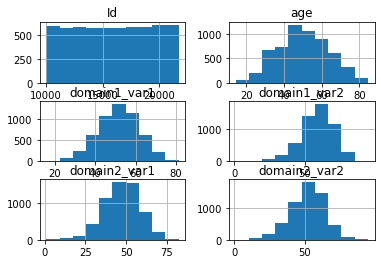

In [9]:
y_data.hist()

## Impute missing data

Imputation strategie **IGNORE_ON_TRAIN**:
- Some of the target values are empty. To ignore the empty one when calculating the loss the missing data is filled with 0 (0 is not in the target range). 0 is used later on as flag in the loss function as prediction to ignore.

Imputation strategie **MEAN**:
- Impute missing targets with mean. They will be included in the loss function. This strategie is worse than IGNORE_ON_TRAIN.

In [10]:
if IMPUTATION_STRAT == 'IGNORE_ON_TRAIN':
    ## will later ignore the value when executing the loss function
    y_data = y_data.fillna(0)
else: #'MEAN'
    y_data = y_data.fillna(y_data.mean())
    
y_data

,Id,age,domain1_var1,domain1_var2,domain2_var1,domain2_var2
0,10001,57.436077,30.571975,62.553736,53.325130,51.427998
1,10002,59.580851,50.969456,67.470628,60.651856,58.311361
2,10004,71.413018,53.152498,58.012103,52.418389,62.536641
3,10005,66.532630,0.000000,0.000000,52.108977,69.993075
4,10007,38.617381,49.197021,65.674285,40.151376,34.096421
...,...,...,...,...,...,...
5872,21746,14.257265,21.358872,61.165998,51.778483,54.640179
5873,21747,55.456978,68.169675,29.907995,55.349257,54.019517
5874,21750,48.948756,55.114811,60.878271,38.617246,50.679885
5875,21752,66.532630,59.844808,72.303110,55.458281,46.870235


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fb79c675450>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x7fb79c548a90>]], dtype=object)

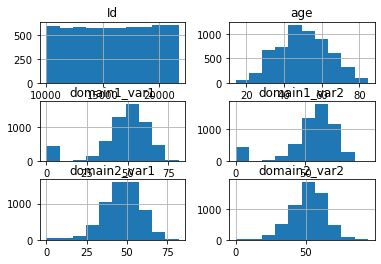

In [11]:
y_data.hist()

# lots of imputed data on domain1_var1/2

## Combine Xs and Ys

In [12]:
train_df = l_data.merge(y_data, on='Id', how='inner').sort_values(by='Id').reset_index(drop = True)
idx_train = train_df.pop('Id') 
train_df

,IC_01,IC_07,IC_05,IC_16,IC_26,IC_06,IC_10,IC_09,IC_18,IC_04,...,DMN_DMN_c1_2,CBN_DMN_c0_2,CBN_DMN_c1_2,CBN_CBN_c0_2,CBN_CBN_c1_2,age,domain1_var1,domain1_var2,domain2_var1,domain2_var2
0,0.006070,0.014466,0.004136,0.000658,-0.002742,0.005033,0.016720,0.003484,0.001797,0.029223,...,0.554125,0.774757,0.945126,0.352743,0.869366,57.436077,30.571975,62.553736,53.325130,51.427998
1,0.009087,0.009291,0.007049,-0.002076,-0.002227,0.004605,0.012277,0.002946,0.004086,0.027333,...,0.916361,1.065385,1.673043,0.431890,0.364208,59.580851,50.969456,67.470628,60.651856,58.311361
2,0.004675,0.000957,0.006154,-0.000429,-0.001222,0.011755,0.013010,0.000193,0.008075,0.027787,...,0.741357,0.636016,1.139628,0.180334,0.668381,71.413018,53.152498,58.012103,52.418389,62.536641
3,-0.000398,0.006878,0.009051,0.000369,0.000336,0.010679,0.010352,0.003637,0.004180,0.021058,...,0.703537,0.650595,0.744056,0.265985,0.628470,66.532630,0.000000,0.000000,52.108977,69.993075
4,0.005192,0.010585,0.012160,-0.000920,-0.002255,0.011416,0.013838,0.001929,0.003051,0.031867,...,0.777800,0.611308,0.794117,0.349987,0.292533,38.617381,49.197021,65.674285,40.151376,34.096421
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5872,-0.001115,0.007108,0.008652,0.003596,0.000950,0.016314,0.017090,0.003513,0.004217,0.027352,...,0.405853,0.499590,0.994129,0.145129,0.689650,14.257265,21.358872,61.165998,51.778483,54.640179
5873,0.007263,0.016489,0.012704,0.004357,-0.005044,0.013909,0.019284,-0.006267,-0.000456,0.031161,...,1.096595,0.937961,1.142857,0.611657,0.153896,55.456978,68.169675,29.907995,55.349257,54.019517
5874,0.005996,0.003873,0.012353,0.000242,-0.002159,0.020201,0.020931,0.003684,-0.002458,0.033895,...,1.022526,0.695594,1.178962,0.442778,0.269252,48.948756,55.114811,60.878271,38.617246,50.679885
5875,0.000627,0.011407,0.010957,0.000534,-0.000347,0.013499,0.010541,0.001867,0.007447,0.020901,...,0.822079,0.604629,0.783760,0.330336,0.372306,66.532630,59.844808,72.303110,55.458281,46.870235


In [13]:
test = l_data.merge(y_data, on='Id', how='outer', indicator = True)
test = test[test['_merge'] == 'left_only'].drop(['age',
                                                 'domain1_var1', 
                                                 'domain1_var2',
                                                 'domain2_var1',
                                                 'domain2_var2',
                                                 '_merge'], axis = 1).sort_values(by='Id').reset_index(drop = True)
idx_test = test.pop('Id') 
test

,IC_01,IC_07,IC_05,IC_16,IC_26,IC_06,IC_10,IC_09,IC_18,IC_04,...,DMN_CON_c0_2,DMN_CON_c1_2,CBN_CON_c0_2,CBN_CON_c1_2,DMN_DMN_c0_2,DMN_DMN_c1_2,CBN_DMN_c0_2,CBN_DMN_c1_2,CBN_CBN_c0_2,CBN_CBN_c1_2
0,0.008151,0.014684,0.010444,-0.005293,-0.002913,0.015042,0.017745,0.003930,-0.008021,0.038530,...,2.171499,2.186715,1.314675,1.345713,0.614549,1.018815,1.066457,0.756163,0.622682,0.243977
1,0.000334,0.005311,0.010053,0.006920,-0.000065,0.015310,0.016543,0.004794,0.003982,0.038693,...,1.949587,2.023351,1.584161,1.073467,0.983679,0.629360,0.674283,0.619425,0.464232,0.326924
2,0.007103,0.006144,0.009770,-0.002884,-0.001346,0.015651,0.011613,-0.003291,0.013423,0.033243,...,1.978522,1.590796,0.902407,1.587303,0.860946,0.602656,0.692454,0.998844,0.402457,0.544250
3,0.004362,0.010240,0.010167,0.004492,-0.001623,0.017381,0.014680,0.007453,0.008786,0.029094,...,2.195222,1.898412,1.262874,1.230146,0.690033,0.604295,0.779272,0.914940,0.313393,0.351968
4,-0.007521,-0.003918,0.008434,-0.001145,0.002017,0.015065,0.019616,0.004140,-0.003744,0.027038,...,2.984475,2.917595,1.519843,1.111420,1.213952,0.871635,1.120645,1.620902,0.530825,0.203649
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5872,0.005406,0.006275,0.012252,0.003518,0.001400,0.015054,0.015373,0.001532,0.003546,0.035930,...,2.303537,2.538704,1.495977,1.320603,0.715815,0.969325,1.011907,0.777737,0.418047,0.438926
5873,0.004240,0.009213,0.010981,0.000443,-0.003072,0.010702,0.014673,0.005523,0.005780,0.022570,...,2.183200,2.469407,1.193541,1.897223,0.974458,1.113125,0.634399,1.101695,0.560017,0.343847
5874,0.004783,0.017910,0.012128,-0.005683,-0.011613,0.017000,0.007230,0.001315,0.008788,0.030379,...,1.692904,1.731665,1.395958,2.007199,0.528611,0.644845,0.784578,0.917943,0.362292,0.477832
5875,0.003835,0.015067,0.015428,-0.002030,0.001205,0.012396,0.011026,-0.001491,0.005310,0.023853,...,2.722291,2.346500,2.476566,2.905256,0.929018,0.863913,1.520354,1.580052,0.635350,0.214796


## Prepare validation splits

### Bin y data for stratified k fold.

The targets are classified in about ***n*** equaly sized buckets. The first bucket containing the smallest values and the n^th bucket containing the highest values. Later on the stratified split will treat these buckets as classes, so every split gets about the same target distribution.

A stratified k fold with 7 folds works best on ***bin_age_7***. 

In [14]:
for d in DEP_VAR:
    y_data['bin_'+d] = pd.qcut(y_data[d].rank(method='first'), q=4, labels=False)

y_data['bin_all'] = (y_data['bin_age']+
                    y_data['bin_domain1_var1']*10+
                    y_data['bin_domain1_var2']*100+
                    y_data['bin_domain2_var1']*1000+
                    y_data['bin_domain2_var2']*10000)

y_data['bin_age_10'] = pd.qcut(y_data['age'].rank(method='first'), q=10, labels=False)

y_data['bin_age_7'] = pd.qcut(y_data['age'].rank(method='first'), q=7, labels=False)

if INCLUDE_AV_DATA:
    y_data = y_data.merge(av_data[['Id','is_test_prob']])
    y_data['bin_test_7'] = pd.qcut(y_data['is_test_prob'].rank(method='first'), q=7, labels=False)

y_data

,Id,age,domain1_var1,domain1_var2,domain2_var1,domain2_var2,bin_age,bin_domain1_var1,bin_domain1_var2,bin_domain2_var1,bin_domain2_var2,bin_all,bin_age_10,bin_age_7
0,10001,57.436077,30.571975,62.553736,53.325130,51.427998,2,0,2,2,1,12202,6,4
1,10002,59.580851,50.969456,67.470628,60.651856,58.311361,2,2,3,3,2,23322,7,5
2,10004,71.413018,53.152498,58.012103,52.418389,62.536641,3,2,1,2,3,32123,9,6
3,10005,66.532630,0.000000,0.000000,52.108977,69.993075,3,0,0,2,3,32003,8,6
4,10007,38.617381,49.197021,65.674285,40.151376,34.096421,0,1,2,1,0,1210,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5872,21746,14.257265,21.358872,61.165998,51.778483,54.640179,0,0,2,2,2,22200,0,0
5873,21747,55.456978,68.169675,29.907995,55.349257,54.019517,2,3,0,3,2,23032,6,4
5874,21750,48.948756,55.114811,60.878271,38.617246,50.679885,1,2,2,0,1,10221,4,3
5875,21752,66.532630,59.844808,72.303110,55.458281,46.870235,3,3,3,3,1,13333,8,6


# Model

## Metrics

In [15]:
def norm_absolute_error(preds, targs):
    # variation of https://github.com/fastai/fastai/blob/master/fastai/metrics.py#L85
    "Normalized absolute error between `pred` and `targ`."
    
    ## use sign for 0 imputeted empty targets, so they wan't be evaluated
    sg=targs.sign()
    y=targs*sg
        
    pred, targ = flatten_check(preds*sg, y)
    return torch.abs(targ - pred).sum() / targ.sum()

def weighted_nae(preds, targs, details = False):
    
    ## use sign for 0 imputeted empty targets, so they wan't be evaluated
    if IMPUTATION_STRAT == 'IGNORE_ON_TRAIN':
        sg = targs.float().sign()
        x0 = preds[:,0].float()*sg[:,0]
        x1 = preds[:,1].float()*sg[:,1]
        x2 = preds[:,2].float()*sg[:,2]
        x3 = preds[:,3].float()*sg[:,3]
        x4 = preds[:,4].float()*sg[:,4]
    else: # 'MEAN'
        sg = 1
        x0 = preds[:,0].float()
        x1 = preds[:,1].float()
        x2 = preds[:,2].float()
        x3 = preds[:,3].float()
        x4 = preds[:,4].float()
            
    y = targs.float()*sg
    
    return norm_absolute_error(x0,y[:,0]), \
           norm_absolute_error(x1,y[:,1]), \
           norm_absolute_error(x2,y[:,2]), \
           norm_absolute_error(x3,y[:,3]), \
           norm_absolute_error(x4,y[:,4]), \
           0.3 * norm_absolute_error(x0,y[:,0]) + \
           0.175 * norm_absolute_error(x1,y[:,1]) + \
           0.175 * norm_absolute_error(x2,y[:,2]) + \
           0.175 * norm_absolute_error(x3,y[:,3]) + \
           0.175 * norm_absolute_error(x4,y[:,4])

def plot_diff(y, y_truth):
    y_df = pd.DataFrame(y.numpy())
    y_df.columns = DEP_VAR
    y_df = y_df.melt()
    y_df['Id'] = y_df.index
    
    y_truth_df = pd.DataFrame(y_truth.numpy())
    y_truth_df.columns = DEP_VAR
    y_truth_df = y_truth_df.melt()
    y_truth_df['Id'] = y_truth_df.index

    plot_df = y_truth_df.merge(y_df, on=['variable', 'Id'], how='inner').drop('Id', axis = 1)
    plot_df.columns = ['Category', 'Target', 'Prediction']

    g = sns.relplot(x="Target", y="Prediction",
                  col="Category", hue="Category", style="Category",
                  kind="scatter", data=plot_df)


The customized metric callback is a variation of https://www.kaggle.com/iafoss/grapheme-fast-ai-starter-lb-0-964. 
It is used to keep track of the five single targets and the combined metric. 

In [16]:
# variation of https://www.kaggle.com/iafoss/grapheme-fast-ai-starter-lb-0-964

class Metric_idx(Callback):
    def __init__(self, idx):
        super().__init__()
        self.idx = idx
        
    def on_epoch_begin(self, **kwargs):
        self.targs, self.preds = Tensor([]), Tensor([])
    
    def on_batch_end(self, last_output:Tensor, last_target:Tensor, **kwargs):
        last_output = last_output[self.idx]
        last_target = last_target[self.idx]
        
        self.preds = torch.cat((self.preds, last_output.float().cpu()))
        self.targs = torch.cat((self.targs, last_target.float().cpu()))
        
    def _norm_absolute_error(self):
        return norm_absolute_error(self.preds, self.targs)
    
    def on_epoch_end(self, last_metrics, **kwargs): 
        return add_metrics(last_metrics, self._norm_absolute_error())

    
Metric_age = partial(Metric_idx,0)
Metric_domain1_var1 = partial(Metric_idx,1)
Metric_domain1_var2 = partial(Metric_idx,2)
Metric_domain2_var1 = partial(Metric_idx,3)
Metric_domain2_var2 = partial(Metric_idx,4)

class Metric_total(Callback):
    def __init__(self):
        super().__init__()
        self.age = Metric_idx(0)
        self.domain1_var1 = Metric_idx(1)
        self.domain1_var2 = Metric_idx(2)
        self.domain2_var1 = Metric_idx(3)
        self.domain2_var2 = Metric_idx(4)
        
    def on_epoch_begin(self, **kwargs):
        self.age.on_epoch_begin(**kwargs)
        self.domain1_var1.on_epoch_begin(**kwargs)
        self.domain1_var2.on_epoch_begin(**kwargs)
        self.domain2_var1.on_epoch_begin(**kwargs)
        self.domain2_var2.on_epoch_begin(**kwargs)
        
    
    def on_batch_end(self, last_output:Tensor, last_target:Tensor, **kwargs):
        self.age.on_batch_end(last_output, last_target, **kwargs)
        self.domain1_var1.on_batch_end(last_output, last_target, **kwargs)
        self.domain1_var2.on_batch_end(last_output, last_target, **kwargs)
        self.domain2_var1.on_batch_end(last_output, last_target, **kwargs)
        self.domain2_var2.on_batch_end(last_output, last_target, **kwargs)
 
        
    def on_epoch_end(self, last_metrics, **kwargs): 
        return add_metrics(last_metrics, 
                           0.3 * self.age._norm_absolute_error() +
                           0.175*self.domain1_var1._norm_absolute_error()  +
                           0.175*self.domain1_var2._norm_absolute_error()  +
                           0.175*self.domain2_var1._norm_absolute_error()  +
                           0.175*self.domain2_var2._norm_absolute_error()
                          )

## Loss function
The customized loss function which consideres five outputs is a variation of https://www.kaggle.com/iafoss/grapheme-fast-ai-starter-lb-0-964. It weights and combines the five single losses.

***MSE*** works best. Best weights are 0.3, 4x0.175 (0.4 and 4x0.15 was promising too).

In [17]:
# variation of https://www.kaggle.com/iafoss/grapheme-fast-ai-starter-lb-0-964

class Loss_combine(nn.Module):
    def __init__(self, loss_weights = [0.4,0.15,0.15,0.15,0.15], loss_base = 'MSE'):
        super().__init__()
        
        self.loss_base = loss_base
        
        self.loss_weights = loss_weights
        self.fw = Tensor(LOSS_WEIGHTS).cuda()
          
            
    def forward(self, input, target,reduction='mean'): #mean
        
        x0,x1,x2,x3,x4 = input.T
        
        ## use sign for 0 imputeted empty targets, so they wan't be evaluated
        if IMPUTATION_STRAT == 'IGNORE_ON_TRAIN':
            sg = target.float().sign()
            x0,x1,x2,x3,x4 = x0.float()*sg[:,0],x1.float()*sg[:,1],x2.float()*sg[:,2],x3.float()*sg[:,3],x4.float()*sg[:,4]
        else: # 'MEAN'
            sg = 1
            x0,x1,x2,x3,x4 = x0.float(),x1.float(),x2.float(),x3.float(),x4.float()
            
        y = target.float()*sg
        
        loss1 = 0
        loss2 = 0
        if self.loss_base in ('MSE','MIX'):
            loss_func = F.mse_loss 
            #reduction = 'sum'
            #loss1 = self.fw[0]*loss_func(x0,y[:,0],reduction=reduction)/sum(y[:,0]**2) + \
            #   self.fw[1]*loss_func(x1,y[:,1],reduction=reduction)/sum(y[:,1]**2) + \
            #   self.fw[2]*loss_func(x2,y[:,2],reduction=reduction)/sum(y[:,2]**2) + \
            #   self.fw[3]*loss_func(x3,y[:,3],reduction=reduction)/sum(y[:,3]**2) + \
            #   self.fw[4]*loss_func(x4,y[:,4],reduction=reduction)/sum(y[:,4]**2)
            
            loss1 = (self.fw*(F.mse_loss(input*sg,y,reduction='none').sum(dim=0))/((y**2.5).sum(dim=0)))*3
            loss1 = loss1.sum()
        
        if self.loss_base in ('L1','MIX'):
            loss_func = F.l1_loss 
            #reduction = 'mean'
            #loss2 =  self.fw[0]*loss_func(x0,y[:,0],reduction=reduction) + \
            #   self.fw[1]*loss_func(x1,y[:,1],reduction=reduction) + \
            #   self.fw[2]*loss_func(x2,y[:,2],reduction=reduction) + \
            #   self.fw[3]*loss_func(x3,y[:,3],reduction=reduction) + \
            #   self.fw[4]*loss_func(x4,y[:,4],reduction=reduction)
            
            reduction = 'sum'
            loss2 =  self.fw[0]*loss_func(x0,y[:,0],reduction=reduction)/sum(y[:,0]) + \
               self.fw[1]*loss_func(x1,y[:,1],reduction=reduction)/sum(y[:,1]) + \
               self.fw[2]*loss_func(x2,y[:,2],reduction=reduction)/sum(y[:,2]) + \
               self.fw[3]*loss_func(x3,y[:,3],reduction=reduction)/sum(y[:,3]) + \
               self.fw[4]*loss_func(x4,y[:,4],reduction=reduction)/sum(y[:,4])
            loss2 = loss2/4

        return loss1 + loss2 #/100


## Build the model

Routing time series features through an LSTM and bypassing the other feature to the linear model.

Tutorials to build LSTM in pytorch: https://stackabuse.com/time-series-prediction-using-lstm-with-pytorch-in-python/, https://www.jessicayung.com/lstms-for-time-series-in-pytorch/

In [18]:
class TailBlock(nn.Module):
    
    def __init__(self, bs):
        super(TailBlock, self).__init__()
        
        self.bs = bs
        self.lstm = nn.GRU(input_size = 53, hidden_size = 20, num_layers = 64, bidirectional=False, dropout = 0.3) # input, layers
        self.linear = nn.Linear(40, 8)
        
        # init hidden cells
        #self.hidden_cell = (torch.zeros(64,bs, 20).cuda(), 
        #                    torch.zeros(64,bs, 20).cuda())  #h_n, c_n => num_layers, batch_size, hidden_dim
        self.hidden_cell = torch.zeros(128,bs, 20).cuda() #,
                           # torch.zeros(128,bs, 20).cuda())

    def forward(self,x_cont):# x_cat, x_cont):
        print(x_cont.size())
        #print(x_cat.size())
        
        x_non_lstm_feat = x_cont[:,:-5300]
        
        x53 = x_cont[:,-5300:].view(-1, 100, 53)
        print('x53',x53.shape)
        lstm_out, self.hidden_cell = self.lstm(x53.view(100, self.bs, -1), self.hidden_cell)
        print('lout',lstm_out.shape)
        x_lstm_out  = self.linear(torch.cat([x_non_lstm_feat.view(1,-1) , x_lstm_out.view(1,-1)], dim=1)) #lstm_out[-1].view(self.bs, -1))
        
        #print(torch.cat([x_non_lstm_feat , x_lstm_out.view(-1)], dim=1).shape)
        #return x_cat, 
        return x_lstm_out #,torch.cat([x_non_lstm_feat.view(1,-1) , x_lstm_out.view(1,-1)], dim=1)

A neck or head module that separetes the "route" of one feature from four others. The idea is that ***age*** needs to be evaluated differntly than the ***domain_var*** values.

It only has a tiny impact on the model. I tried it as head and as neck. Head worked better. Not sure if it considered the target y_ranges (see **prep_learn**-definition below) if it is used as head.

In [19]:
class NeckBlock(nn.Module):
    
    def __init__(self, nf, ps=0.3):
        super(NeckBlock,self).__init__()
        
        self.sa = SelfAttention(256)
        
        # age
        self.bn1 = nn.BatchNorm1d(nf)
        self.d1 = nn.Dropout(ps)
        self.l1 = nn.Linear(nf, 1)
        #self.l1b = nn.Linear(nf, 1)
        self.act1 = nn.LeakyReLU(0.1, inplace=True)
        
        # dom_var
        self.bn2 = nn.BatchNorm1d(nf)
        self.d2 = nn.Dropout(ps)
        self.l2 = nn.Linear(nf, 4)
        self.act2 = nn.LeakyReLU(0.1, inplace=True)
        
        #self.bn2b = nn.BatchNorm1d(nf)
        #self.d2b = nn.Dropout(0.3)
        #self.l2b = nn.Linear(nf, 4)
        #self.act2b = nn.LeakyReLU(0.1, inplace=True)
        
    def forward(self, x):
        ident = x
        
        x0 = self.sa(x)
        
        x1 = self.bn1(x0)
        x1 = self.d1(x1)
        x1 = self.l1(x1)
        #x1 = self.l1b(x1)
        x1 = self.act1(x1+ident)
        
        x2 = self.bn2(x0) #+x1
        x2 = self.d2(x2)
        x2 = self.l2(x2)
        #x2 = self.l2b(x2)
        x2 = self.act2(x2+ident)
               
        return x1, xn
        


Define the dataloader (wrapped in a fastai databunch).

Define the fastai learner. Surprisingly the best model was just 1 hidden layer with 8 neurons! ps=0.3 (DropOut) is used for regularization. y_range defines the range bounderies for the predictions and has some positive effect on some configurations.

In [20]:
def prep_data(bs=128, valid_idx=range(200, 400), train_df = train_df):
    procs = [FillMissing, Categorify, Normalize]
    
    cat_names = []
    if INCLUDE_FNC_CLUSTERS:
        cat_names = cat_names + list(set(c_data.columns)-set(['Id']))

    if INCLUDE_FNC_CLUSTERS_2:
        cat_names = cat_names + list(set(c2_data.columns)-set(['Id']))
    
    
    cont_names = list(set(train_df.columns) - set(cat_names) - set(['age','domain1_var1','domain1_var2', 'domain2_var1', 'domain2_var2'])-set(DEP_VAR))
    tlist = (TabularList.from_df(train_df, 
                                path=kaggle_path, 
                                cat_names=cat_names, 
                                cont_names=cont_names, 
                                procs=procs))

    if valid_idx == None:
        tlist = tlist.split_none()
    else:
        tlist = tlist.split_by_idx(valid_idx)

    data = (tlist.label_from_df(cols=DEP_VAR)
                 .add_test(TabularList.from_df(test, 
                                               cat_names=cat_names,
                                               cont_names=cont_names, 
                                               procs = procs))
                 .databunch(path = kaggle_path, bs = bs))
    
    return data


def prep_learn(data, loss_base = 'MSE'):
    
    learn = tabular_learner(data, 
                        #! only one hidden 8 neuron layer works best
                        layers = [8], #[64,8], # [256,128,256,128,64], #[1024,1024,128,1024,128,1024,1024],#[8], #
                        # Drop Out 0.3 works best
                        ps = 0.3, #.4
                        loss_func = Loss_combine(loss_weights = LOSS_WEIGHTS,  loss_base= loss_base),
                        metrics=[Metric_age(),
                                 Metric_domain1_var1(),
                                 Metric_domain1_var2(),
                                 Metric_domain2_var1(),
                                 Metric_domain2_var2(),
                                 Metric_total()],
                       # not sure if y_range is applied when using the NeckBlock module as head
                       y_range=(Tensor([12,12,0,0,0]).cuda(),Tensor([90,90,100,100,100]).cuda())
                       #y_range=(Tensor([0,0,0,0,0]).cuda(),Tensor([1,1,1,1,1]).cuda())
                       #y_range=(Tensor([12,12,0,0,0]).cuda(),Tensor([90,90,100,100,100]).cuda())     
                       )#.to_fp16()
    
    learn.clip_grad = 1.0
    # adding head/neck module
    learn.model.layers[4].add_module('NeckBlock', NeckBlock(5, 0.4))
    # learn.model = nn.Sequential(TailBlock(1),learn.model)
    # learn.model.bn_cont.add_module('TailBlock', TailBlock(1))
    #learn.model.layers[0].add_module('TailBlock', TailBlock(1))
    #learn.model.cuda()
    return learn
    

## Let's run a first training

In [21]:
#train500= train_df.head(500)#

In [22]:
#train500.shape

In [23]:
bs=128
valid_idx=range(200, 400)

data = prep_data(bs, valid_idx, train_df=train_df)
learn = prep_learn(data)

In [24]:
#learn.model #summary()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 3.98E-02
Min loss divided by 10: 1.32E-01


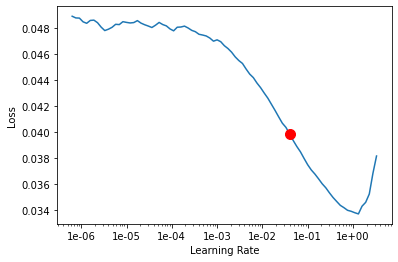

In [25]:
learn.lr_find()
learn.recorder.plot(suggestion=True)

In [26]:
lr = 2e-2
reduceLR = callbacks.ReduceLROnPlateauCallback(learn=learn, monitor = 'valid_loss', mode = 'auto', patience = 2, factor = 0.2, min_delta = 0)
learn.fit_one_cycle(10, lr, callbacks=[reduceLR])

epoch,train_loss,valid_loss,metric_idx,metric_idx,metric_idx,metric_idx,metric_idx,metric_total,time
0,0.031395,0.023090,0.174184,0.185601,0.170829,0.236557,0.200060,0.191039,00:01
1,0.023112,0.018946,0.176954,0.185916,0.119077,0.164218,0.163119,0.163744,00:01
2,0.019236,0.017640,0.160282,0.212023,0.120001,0.180155,0.146633,0.163377,00:01
3,0.017466,0.016982,0.169579,0.208476,0.115566,0.180800,0.144094,0.164438,00:01
4,0.016621,0.016974,0.164182,0.211082,0.118657,0.171504,0.140146,0.161498,00:01
5,0.016140,0.016439,0.149123,0.205585,0.116925,0.163200,0.146615,0.155394,00:01
6,0.015789,0.016419,0.146903,0.203777,0.120047,0.165845,0.131141,0.152713,00:01
7,0.015483,0.016453,0.139067,0.207283,0.115752,0.174586,0.127812,0.151171,00:01
8,0.015296,0.016284,0.140313,0.200242,0.114930,0.159907,0.127975,0.147628,00:01
9,0.015124,0.016248,0.138507,0.199489,0.115224,0.160104,0.127567,0.146969,00:01


Without augmentation:
Weighted normalized absolute error (Valid): 0.16232319176197052
NAE age (Valid): 0.14971651136875153
NAE domain1_var1 (Valid): 0.14921382069587708
NAE domain1_var2 (Valid): 0.17060154676437378
NAE domain2_var1 (Valid): 0.1721603125333786
NAE domain2_var2 (Valid): 0.17892864346504211


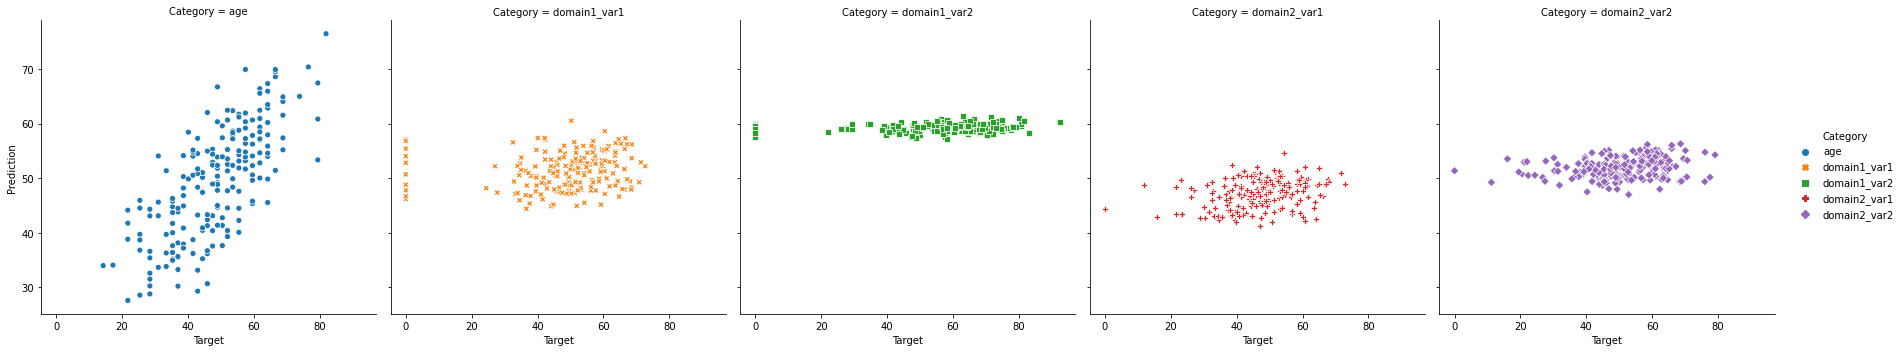

In [27]:
yv, yv_truth= learn.get_preds(ds_type=DatasetType.Valid)
yt, yt_truth= learn.get_preds(ds_type=DatasetType.Train)

print(f'Without augmentation:')
print(f'Weighted normalized absolute error (Valid): {weighted_nae(yv,yv_truth)[-1]}')
for i, dv in enumerate(DEP_VAR):
    print(f'NAE {dv} (Valid): {weighted_nae(yv,yv_truth)[i]}')
plot_diff(yv, yv_truth)

The unseen validation set fitting best on the age target. The metrics in the epoch stats table are different than the final scores. But the tendencies in all the experiments I run where the same, so I didn't investigate further.

I think it's also good to have a look after predicting your train data. It's not saying anything about unseen data. But it gives you a feeling how over-/underfit the model is.

Weighted normalized absolute error (Train): 0.1518053412437439
NAE age (Train): 0.12859933078289032
NAE domain1_var1 (Train): 0.14737673103809357
NAE domain1_var2 (Train): 0.1497790813446045
NAE domain2_var1 (Train): 0.17750537395477295
NAE domain2_var2 (Train): 0.1723419427871704


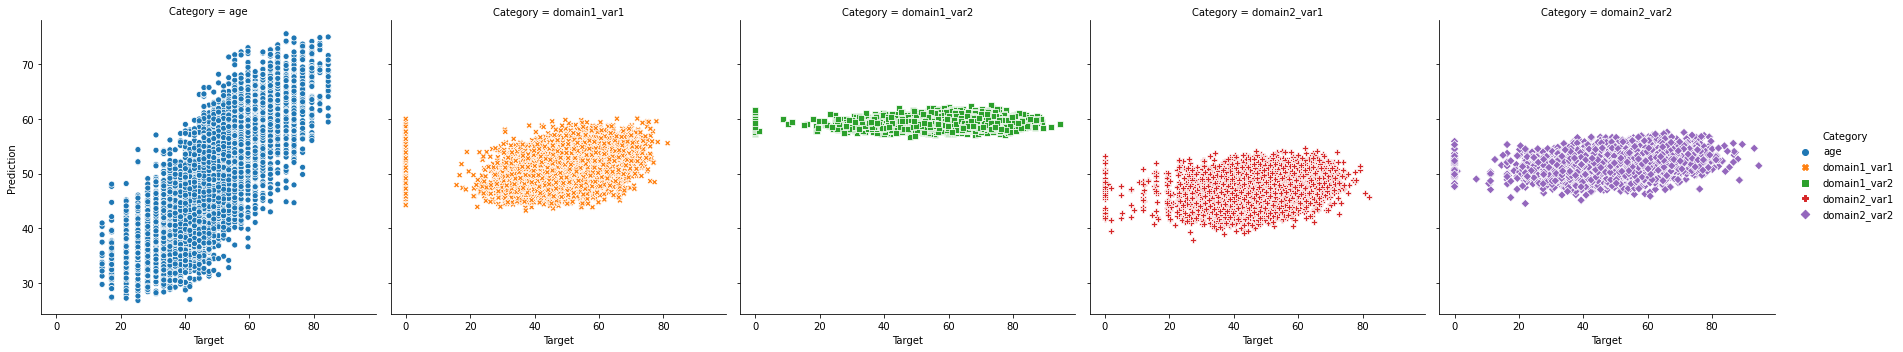

In [28]:
print(f'Weighted normalized absolute error (Train): {weighted_nae(yt,yt_truth)[-1]}')
for i, dv in enumerate(DEP_VAR):
    print(f'NAE {dv} (Train): {weighted_nae(yt,yt_truth)[i]}')
plot_diff(yt, yt_truth)

### K-Fold Playground

10 Folds on ***bin_age_7*** with 10 epochs and max_lr = 4e-2 work the best.

Fold #: 0


epoch,train_loss,valid_loss,metric_idx,metric_idx,metric_idx,metric_idx,metric_idx,metric_total,time
0,0.029838,0.020257,0.190075,0.197880,0.191509,0.164827,0.200630,0.189121,00:01
1,0.022431,0.017048,0.183742,0.188395,0.174641,0.159921,0.195425,0.180839,00:01
2,0.019087,0.016215,0.162478,0.185516,0.185973,0.162070,0.188045,0.175024,00:01
3,0.017563,0.015887,0.166888,0.175604,0.181805,0.164529,0.190244,0.174698,00:01
4,0.016703,0.015812,0.167160,0.182406,0.176829,0.161730,0.188243,0.174259,00:01
5,0.016242,0.015881,0.161653,0.174523,0.176262,0.155464,0.172919,0.167350,00:01
6,0.015895,0.015919,0.159812,0.174363,0.172080,0.165774,0.182270,0.169479,00:01
7,0.015624,0.015784,0.159418,0.175016,0.172282,0.156910,0.182949,0.168078,00:01
8,0.015376,0.015677,0.160984,0.178303,0.170805,0.156926,0.183247,0.168919,00:01
9,0.015176,0.015656,0.160052,0.176562,0.171803,0.157477,0.183871,0.168716,00:01


Fold #: 1


epoch,train_loss,valid_loss,metric_idx,metric_idx,metric_idx,metric_idx,metric_idx,metric_total,time
0,0.038153,0.022164,0.215274,0.265282,0.159504,0.186159,0.176985,0.202470,00:01
1,0.025273,0.017725,0.159313,0.209725,0.147532,0.157719,0.165375,0.166855,00:01
2,0.020205,0.016685,0.159120,0.208503,0.141672,0.152144,0.168721,0.165168,00:01
3,0.018126,0.016149,0.149354,0.214316,0.142467,0.149922,0.166244,0.162572,00:01
4,0.016947,0.015860,0.149826,0.214803,0.136573,0.156039,0.162911,0.162255,00:01
5,0.016275,0.016111,0.142771,0.205407,0.147516,0.147761,0.163752,0.159108,00:01
6,0.015902,0.015878,0.157390,0.217029,0.133144,0.147838,0.166168,0.163448,00:01
7,0.015598,0.015671,0.149443,0.210920,0.138116,0.147423,0.162463,0.160144,00:01
8,0.015296,0.015638,0.146215,0.215290,0.137821,0.146934,0.165614,0.160355,00:01
9,0.015167,0.015626,0.147422,0.213737,0.136552,0.146386,0.165261,0.160065,00:01


Fold #: 2


epoch,train_loss,valid_loss,metric_idx,metric_idx,metric_idx,metric_idx,metric_idx,metric_total,time
0,0.031166,0.021652,0.248765,0.187985,0.207779,0.185565,0.196694,0.210783,00:01
1,0.022410,0.017463,0.233292,0.206208,0.192392,0.185365,0.184759,0.204514,00:01
2,0.018831,0.017131,0.236050,0.211902,0.186718,0.184480,0.175979,0.203654,00:01
3,0.017238,0.016864,0.222707,0.205338,0.187632,0.169350,0.179643,0.196656,00:01
4,0.016496,0.016444,0.218551,0.198267,0.192067,0.177749,0.164235,0.193721,00:01
5,0.016002,0.016367,0.221068,0.207888,0.185527,0.168765,0.165300,0.193629,00:01
6,0.015572,0.016233,0.222802,0.194430,0.184053,0.175304,0.166507,0.192892,00:01
7,0.015315,0.016117,0.223507,0.198966,0.186200,0.165535,0.166054,0.192484,00:01
8,0.015074,0.015943,0.216932,0.196741,0.183326,0.164826,0.163864,0.189112,00:01
9,0.014859,0.015959,0.217525,0.199000,0.183182,0.162749,0.165701,0.189618,00:01


Fold #: 3


epoch,train_loss,valid_loss,metric_idx,metric_idx,metric_idx,metric_idx,metric_idx,metric_total,time
0,0.030154,0.021490,0.199370,0.249930,0.211708,0.266355,0.201557,0.222482,00:01
1,0.022279,0.017382,0.189033,0.229685,0.189109,0.213743,0.190681,0.200773,00:01
2,0.018926,0.017112,0.181661,0.223816,0.182768,0.212153,0.191463,0.196283,00:01
3,0.017381,0.016457,0.177204,0.225955,0.183721,0.211798,0.191247,0.195387,00:01
4,0.016538,0.016348,0.186091,0.227867,0.178851,0.209404,0.185636,0.196135,00:01
5,0.015994,0.016694,0.183509,0.234396,0.175627,0.210337,0.182716,0.195591,00:01
6,0.015580,0.016273,0.184845,0.229245,0.176934,0.210104,0.179839,0.194775,00:01
7,0.015324,0.016216,0.181686,0.230166,0.174649,0.207708,0.178033,0.192853,00:01
8,0.015115,0.016184,0.181733,0.230266,0.177646,0.208963,0.181525,0.194240,00:01
9,0.014902,0.016141,0.181679,0.230334,0.177132,0.208595,0.181457,0.194070,00:01


Fold #: 4


epoch,train_loss,valid_loss,metric_idx,metric_idx,metric_idx,metric_idx,metric_idx,metric_total,time
0,0.033626,0.020809,0.191681,0.188723,0.181925,0.155537,0.200346,0.184647,00:01
1,0.023627,0.016785,0.199035,0.166061,0.170039,0.129093,0.167806,0.170485,00:01
2,0.019603,0.016270,0.196529,0.162519,0.157028,0.130583,0.161110,0.165926,00:01
3,0.017786,0.016163,0.189821,0.159013,0.159047,0.129158,0.170973,0.165130,00:01
4,0.016835,0.015991,0.195556,0.162584,0.161160,0.133969,0.154884,0.165871,00:01
5,0.016215,0.015716,0.193551,0.156853,0.160737,0.143261,0.161571,0.166989,00:01
6,0.015837,0.015709,0.193195,0.158464,0.158552,0.134436,0.158504,0.164701,00:01
7,0.015517,0.015656,0.192630,0.155048,0.160966,0.136411,0.152322,0.163620,00:01
8,0.015201,0.015499,0.196070,0.160075,0.156966,0.133516,0.158091,0.165334,00:01
9,0.015024,0.015470,0.193433,0.158978,0.157239,0.135169,0.159466,0.164929,00:01


Fold #: 5


epoch,train_loss,valid_loss,metric_idx,metric_idx,metric_idx,metric_idx,metric_idx,metric_total,time
0,0.033097,0.022390,0.156535,0.232483,0.193547,0.196658,0.195863,0.190207,00:01
1,0.023432,0.016912,0.151424,0.178028,0.171001,0.155136,0.153755,0.160563,00:01
2,0.019496,0.016103,0.144801,0.173231,0.166624,0.148883,0.160645,0.157082,00:01
3,0.017709,0.016403,0.146352,0.175604,0.164233,0.151376,0.156512,0.157257,00:01
4,0.016830,0.015544,0.136021,0.170060,0.162917,0.143357,0.148098,0.150082,00:01
5,0.016334,0.015906,0.148889,0.174914,0.159568,0.137420,0.149583,0.153427,00:01
6,0.015944,0.015402,0.136419,0.162188,0.155197,0.133237,0.141824,0.144604,00:00
7,0.015642,0.015485,0.140537,0.170268,0.155281,0.143494,0.146734,0.149922,00:01
8,0.015388,0.015359,0.138098,0.161714,0.153213,0.142090,0.144693,0.146728,00:01
9,0.015247,0.015342,0.137848,0.160723,0.154322,0.140385,0.144288,0.146305,00:01


Fold #: 6


epoch,train_loss,valid_loss,metric_idx,metric_idx,metric_idx,metric_idx,metric_idx,metric_total,time
0,0.030987,0.020308,0.239252,0.197145,0.189088,0.199019,0.196475,0.208578,00:01
1,0.022790,0.016573,0.199829,0.184881,0.185414,0.188340,0.188785,0.190747,00:01
2,0.019333,0.015781,0.194986,0.186616,0.188222,0.180698,0.191675,0.189258,00:01
3,0.017604,0.015483,0.184760,0.177937,0.187433,0.178310,0.183232,0.182638,00:01
4,0.016766,0.015260,0.192409,0.186343,0.184745,0.178019,0.188978,0.186888,00:01
5,0.016255,0.015149,0.182021,0.187604,0.190894,0.177284,0.186008,0.184419,00:01
6,0.015855,0.014972,0.182738,0.184678,0.190183,0.174762,0.184584,0.183308,00:01
7,0.015678,0.015072,0.188299,0.186809,0.189435,0.171957,0.192559,0.186123,00:01
8,0.015448,0.015021,0.182811,0.185707,0.191088,0.176722,0.185561,0.184182,00:01
9,0.015306,0.014962,0.181775,0.188156,0.192025,0.176241,0.184902,0.184264,00:01


### Total:
Weighted normalized absolute error (Valid): 0.15898090600967407
NAE age (Valid): 0.1446036398410797
NAE domain1_var1 (Valid): 0.15121836960315704
NAE domain1_var2 (Valid): 0.1513879895210266
NAE domain2_var1 (Valid): 0.18161964416503906
NAE domain2_var2 (Valid): 0.17634442448616028


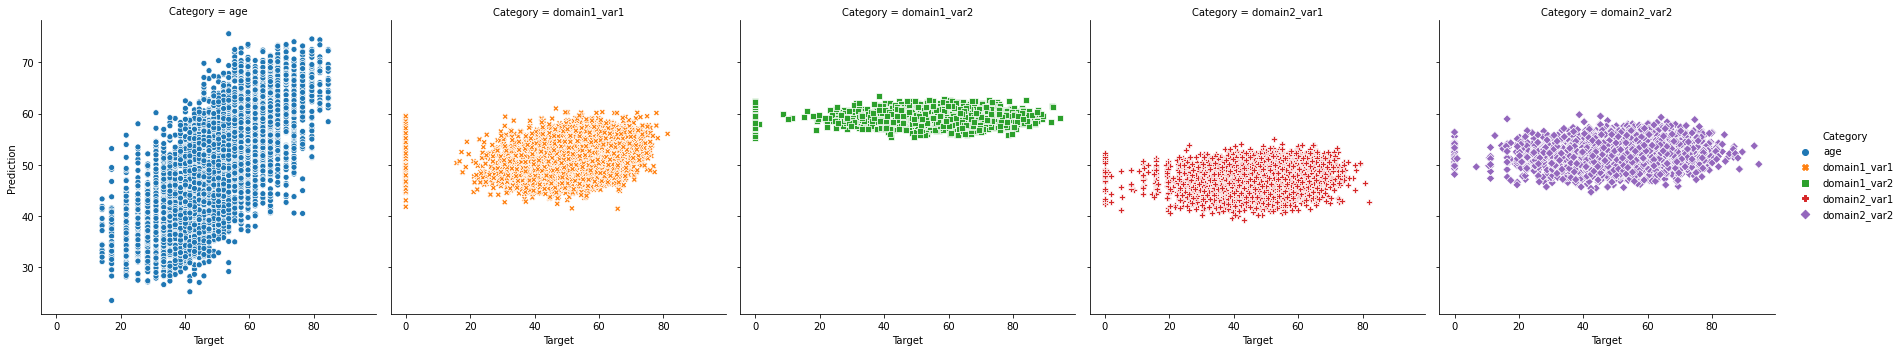

In [29]:
LOSS_WEIGHTS = [.3, .175, .175, .175, .175] #[.4, .15, .15, .15, .15] #[1,0,0,0,0,] #

kf_split = 7
kf = StratifiedKFold(n_splits=kf_split, shuffle=True, random_state=2020)
y_oof = None
y_truth_oof = None
y_oof_g = None
y_truth_oof_g = None
val_ids = []

for i, (train_id, val_id) in enumerate(kf.split(train_df,y_data['bin_age_7'].values)):
    print('Fold #:',i)
    data = prep_data(BS, val_id.tolist())
    learn = prep_learn(data, loss_base = 'MSE')
    
    lr = 4e-2
    reduceLR = callbacks.ReduceLROnPlateauCallback(learn=learn, monitor = 'valid_loss', mode = 'auto', patience = 2, factor = 0.2, min_delta = 0)
    learn.fit_one_cycle(10, lr, callbacks=[reduceLR]) 
    
    val_ids = val_ids+val_id.tolist()

    yv, yv_truth= learn.get_preds(ds_type=DatasetType.Valid)
    if y_oof == None:
        y_oof = yv
        y_truth_oof = yv_truth
    else:
        y_oof=torch.cat((y_oof,yv),0)
        y_truth_oof=torch.cat((y_truth_oof,yv_truth),0)

    
    #print(f'Weighted normalized absolute error (Valid): {weighted_nae(yv,yv_truth)[-1]}')
    #for i, dv in enumerate(DEP_VAR):
    #    print(f'NAE {dv} (Valid): {weighted_nae(yv,yv_truth)[i]}')
    #plot_diff(yv, y_truthv)

print(f'### Total:')
print(f'Weighted normalized absolute error (Valid): {weighted_nae(y_oof,y_truth_oof)[-1]}')
for i, dv in enumerate(DEP_VAR):
    print(f'NAE {dv} (Valid): {weighted_nae(y_oof,y_truth_oof)[i]}')
plot_diff(y_oof, y_truth_oof) # 6: 155

### Total:
Weighted normalized absolute error (Valid): 0.15875516831874847
NAE age (Valid): 0.1444934457540512
NAE domain1_var1 (Valid): 0.15112507343292236
NAE domain1_var2 (Valid): 0.15095332264900208
NAE domain2_var1 (Valid): 0.1814374327659607
NAE domain2_var2 (Valid): 0.17595353722572327


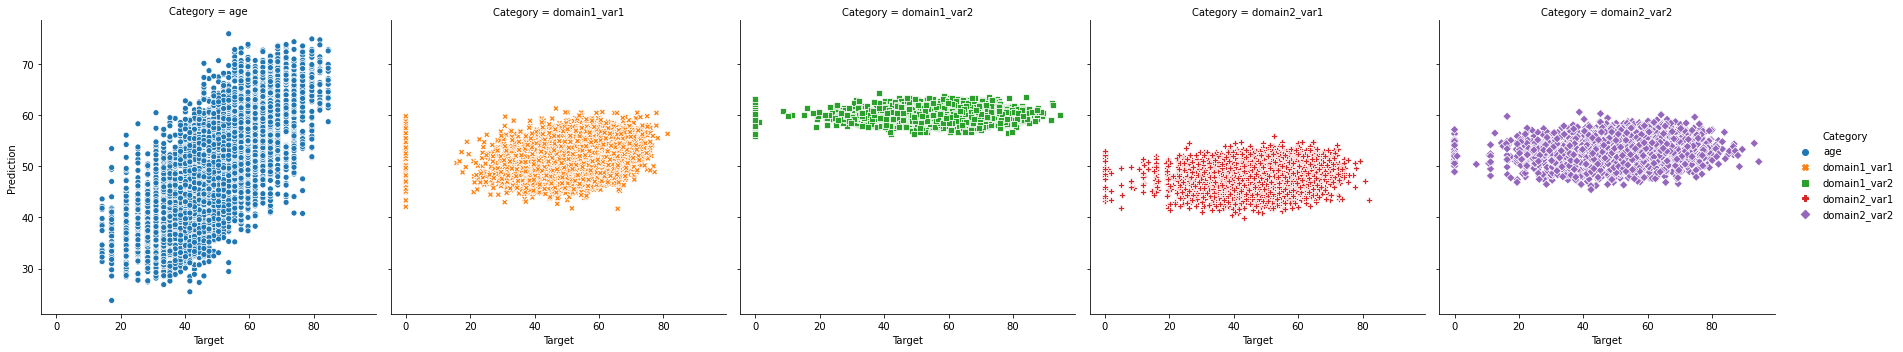

In [30]:
#pd.DataFrame((y_oof+torch.tensor([9,16,19,11,12])-y_truth_oof).numpy()).hist()

offset=torch.tensor([.3,.3,.8,.8,.8])

print(f'### Total:')
print(f'Weighted normalized absolute error (Valid): {weighted_nae(y_oof+offset,y_truth_oof)[-1]}')
for i, dv in enumerate(DEP_VAR):
    print(f'NAE {dv} (Valid): {weighted_nae(y_oof+offset,y_truth_oof)[i]}')
plot_diff(y_oof+offset, y_truth_oof)

### Total:
Weighted normalized absolute error (Valid): 0.15890708565711975
NAE age (Valid): 0.144345223903656
NAE domain1_var1 (Valid): 0.15140166878700256
NAE domain1_var2 (Valid): 0.15128813683986664
NAE domain2_var1 (Valid): 0.18171468377113342
NAE domain2_var2 (Valid): 0.17618706822395325

### Total:
Weighted normalized absolute error (Valid): 0.15910734236240387
NAE age (Valid): 0.14428390562534332
NAE domain1_var1 (Valid): 0.15133097767829895
NAE domain1_var2 (Valid): 0.15144872665405273
NAE domain2_var1 (Valid): 0.18138742446899414
NAE domain2_var2 (Valid): 0.17767387628555298

# Prediction

In [31]:
def gather_preds(learn, ignore_vars=[], offset = torch.ones(5)):
    preds = learn.get_preds(ds_type=DatasetType.Test)[0]
    preds = preds + offset
    
    submission=None

    rec_flatt = pd.DataFrame(idx_test)
    rec_flatt.columns=['Id']
    
    for t, tcol in enumerate(DEP_VAR):
        if tcol not in ignore_vars:
            rec = pd.DataFrame(idx_test)
            rec['Id'] = rec['Id'].astype(str)+'_'+tcol
            rec['Predicted'] = preds[:,t]
            if isinstance(submission, pd.DataFrame):
                submission = submission.append(rec)
            else:
                submission = rec
            
        rec_flatt[tcol] = preds[:,t]
            
    return submission, rec_flatt


def make_submission(gathered_preds, filename = ''):
    #submission = gathered_preds.sort_values('Id').reset_index(drop=True)
    submission = gathered_preds.groupby('Id').mean().sort_values('Id').reset_index(drop=False)
    print('Shape of submission:', submission.shape)
    display(submission.head(10))
    submission.to_csv(filename, index=False)

## Predict without split (cross validation)

In [32]:
data = prep_data(BS, valid_idx = None)
learn = prep_learn(data)

lr = 4e-2
learn.fit_one_cycle(10, lr)

In [33]:
gath_pred_no_split, _ = gather_preds(learn)
make_submission(gath_pred_no_split, filename = 'submission_wo_split.csv')

Shape of submission: (29385, 2)


,Id,Predicted
0,10003_age,62.278271
1,10003_domain1_var1,54.850048
2,10003_domain1_var2,59.106823
3,10003_domain2_var1,50.114861
4,10003_domain2_var2,54.383846
5,10006_age,65.264450
6,10006_domain1_var1,56.406555
7,10006_domain1_var2,59.726948
8,10006_domain2_var1,49.534782
9,10006_domain2_var2,52.727600


## Predict K-Fold
10 Folds on ***bin_age_7*** with 10 epochs and max_lr = 4e-2 work the best.

### 10-fold MIX-loss

Fold #: 0


epoch,train_loss,valid_loss,metric_idx,metric_idx,metric_idx,metric_idx,metric_idx,metric_total,time
0,0.087641,0.065266,0.267272,0.174343,0.157157,0.143400,0.151605,0.189820,00:01
1,0.069816,0.059709,0.229521,0.170111,0.122768,0.158673,0.129894,0.170609,00:01
2,0.062683,0.056529,0.222468,0.164906,0.127071,0.152635,0.129977,0.167294,00:01
3,0.059443,0.056853,0.232300,0.176966,0.115682,0.164172,0.116915,0.170094,00:01
4,0.057679,0.055721,0.236225,0.157310,0.126497,0.148648,0.136342,0.170407,00:01
5,0.056517,0.056611,0.230284,0.170613,0.116950,0.163757,0.120857,0.169216,00:01
6,0.055816,0.055390,0.225503,0.160956,0.121382,0.150377,0.120989,0.164549,00:01
7,0.055207,0.055794,0.223132,0.171338,0.117793,0.160330,0.115834,0.165866,00:01
8,0.054699,0.055063,0.230988,0.163343,0.116304,0.146961,0.130439,0.166780,00:01
9,0.054280,0.055021,0.231465,0.164130,0.117593,0.147891,0.128081,0.167036,00:01


Fold #: 1


epoch,train_loss,valid_loss,metric_idx,metric_idx,metric_idx,metric_idx,metric_idx,metric_total,time
0,0.083917,0.065670,0.192419,0.231671,0.168106,0.188887,0.217155,0.198744,00:01
1,0.068472,0.059383,0.191884,0.211388,0.150588,0.177512,0.201883,0.187305,00:01
2,0.062261,0.057574,0.192325,0.210590,0.126646,0.171502,0.201133,0.181925,00:01
3,0.059386,0.056909,0.193813,0.209832,0.123478,0.177214,0.185008,0.179862,00:01
4,0.057869,0.056560,0.201754,0.203801,0.121365,0.175531,0.189268,0.181270,00:01
5,0.056818,0.056596,0.205169,0.206801,0.124321,0.170271,0.189834,0.182515,00:01
6,0.056186,0.056160,0.201259,0.211527,0.125101,0.170851,0.186369,0.181801,00:01
7,0.055525,0.056659,0.207406,0.202887,0.139109,0.174261,0.191508,0.186081,00:01
8,0.054871,0.055958,0.200757,0.205448,0.128742,0.171274,0.189421,0.181832,00:01
9,0.054526,0.055938,0.199928,0.204972,0.132646,0.171326,0.188088,0.181959,00:01


Fold #: 2


epoch,train_loss,valid_loss,metric_idx,metric_idx,metric_idx,metric_idx,metric_idx,metric_total,time
0,0.083622,0.068448,0.189803,0.182263,0.195347,0.198402,0.252570,0.201943,00:01
1,0.069840,0.060255,0.165669,0.137564,0.164781,0.193502,0.262833,0.182470,00:01
2,0.062745,0.057091,0.159987,0.139729,0.154313,0.170973,0.240749,0.171505,00:01
3,0.059702,0.056050,0.157738,0.131199,0.145838,0.170768,0.223816,0.164855,00:01
4,0.057882,0.057192,0.158587,0.125867,0.150919,0.182381,0.255467,0.172637,00:01
5,0.056762,0.056242,0.151081,0.129052,0.148100,0.169224,0.238725,0.165217,00:01
6,0.056014,0.055720,0.155908,0.128311,0.145735,0.168361,0.231679,0.164738,00:01
7,0.055352,0.055700,0.159488,0.133455,0.139777,0.168219,0.231101,0.165543,00:01
8,0.054728,0.055159,0.154657,0.130846,0.142785,0.171744,0.231401,0.164833,00:01
9,0.054493,0.055269,0.154662,0.130396,0.140788,0.171202,0.229994,0.164065,00:01


Fold #: 3


epoch,train_loss,valid_loss,metric_idx,metric_idx,metric_idx,metric_idx,metric_idx,metric_total,time
0,0.088531,0.070400,0.233426,0.161579,0.161673,0.253339,0.162580,0.199383,00:01
1,0.070933,0.062298,0.204376,0.131311,0.143751,0.164446,0.168130,0.167649,00:01
2,0.063209,0.058339,0.203597,0.121948,0.151230,0.175301,0.157564,0.167137,00:01
3,0.059379,0.059650,0.195054,0.118076,0.147856,0.165726,0.177777,0.165167,00:01
4,0.057682,0.057935,0.185570,0.124548,0.154683,0.162650,0.164181,0.161732,00:01
5,0.056642,0.057383,0.188089,0.109880,0.158277,0.160305,0.168868,0.160959,00:01
6,0.055503,0.057054,0.188459,0.118542,0.159632,0.161454,0.167910,0.162857,00:01
7,0.054850,0.056435,0.187029,0.116136,0.158745,0.159769,0.164213,0.160910,00:01
8,0.054279,0.056399,0.184974,0.119742,0.164574,0.161600,0.159375,0.161418,00:01
9,0.053870,0.056439,0.184847,0.119572,0.164072,0.160269,0.161309,0.161368,00:01


Fold #: 4


epoch,train_loss,valid_loss,metric_idx,metric_idx,metric_idx,metric_idx,metric_idx,metric_total,time
0,0.082914,0.065170,0.153653,0.202067,0.161188,0.221256,0.209077,0.184974,00:01
1,0.067066,0.058519,0.135864,0.168374,0.137004,0.185017,0.156505,0.153967,00:01
2,0.061230,0.057156,0.138576,0.169545,0.140563,0.179268,0.149803,0.153429,00:01
3,0.058684,0.057184,0.146005,0.187319,0.143578,0.176702,0.161784,0.160943,00:01
4,0.057404,0.056475,0.139497,0.167617,0.142368,0.172817,0.149521,0.152506,00:01
5,0.056314,0.057185,0.143856,0.182132,0.148158,0.171618,0.167414,0.160288,00:01
6,0.055677,0.056338,0.133135,0.167475,0.144307,0.179375,0.157879,0.153522,00:01
7,0.054933,0.056449,0.132910,0.175893,0.148088,0.181278,0.153136,0.155092,00:01
8,0.054572,0.055632,0.137889,0.171708,0.148673,0.172481,0.154921,0.154729,00:01
9,0.053930,0.055693,0.136521,0.171698,0.148630,0.174548,0.153460,0.154415,00:01


Fold #: 5


epoch,train_loss,valid_loss,metric_idx,metric_idx,metric_idx,metric_idx,metric_idx,metric_total,time
0,0.090959,0.068097,0.161212,0.235939,0.231882,0.163971,0.176468,0.189809,00:01
1,0.070829,0.058565,0.157938,0.222948,0.204179,0.138493,0.150913,0.172775,00:01
2,0.062903,0.057517,0.170013,0.228083,0.190775,0.133512,0.136824,0.171613,00:01
3,0.059302,0.057632,0.159558,0.231849,0.178473,0.139936,0.149239,0.170279,00:01
4,0.057524,0.057827,0.167314,0.228482,0.184688,0.141009,0.154169,0.174155,00:02
5,0.056619,0.057147,0.158141,0.215805,0.182774,0.143315,0.160534,0.170367,00:01
6,0.055633,0.056357,0.171324,0.221090,0.171733,0.131641,0.151735,0.169732,00:01
7,0.054789,0.056371,0.169596,0.215919,0.172432,0.140050,0.157889,0.170979,00:01
8,0.054256,0.056321,0.170333,0.219222,0.169887,0.138685,0.157126,0.170961,00:01
9,0.053576,0.056373,0.169734,0.215907,0.169477,0.139661,0.160180,0.170834,00:02


Fold #: 6


epoch,train_loss,valid_loss,metric_idx,metric_idx,metric_idx,metric_idx,metric_idx,metric_total,time
0,0.091815,0.068789,0.192079,0.175059,0.157553,0.106917,0.235256,0.175711,00:01
1,0.071719,0.059469,0.155487,0.139050,0.135179,0.122938,0.202797,0.151640,00:01
2,0.063467,0.057071,0.146192,0.151053,0.141628,0.115400,0.190761,0.148655,00:01
3,0.059639,0.056523,0.148402,0.155173,0.133543,0.112975,0.198724,0.149593,00:01
4,0.057855,0.055486,0.145317,0.155240,0.145920,0.108563,0.190574,0.148647,00:01
5,0.056876,0.056069,0.151169,0.153386,0.141597,0.102497,0.194793,0.148999,00:01
6,0.055948,0.055933,0.150754,0.158718,0.143809,0.109245,0.206030,0.153342,00:01
7,0.055337,0.056309,0.153025,0.147960,0.144752,0.113169,0.209811,0.153653,00:01
8,0.054737,0.055531,0.152655,0.157205,0.142342,0.104237,0.198958,0.151276,00:01
9,0.054315,0.055440,0.152856,0.155758,0.142741,0.103194,0.201458,0.151408,00:01


Epoch 7: reducing lr to 0.001506066768401896


Fold #: 7


epoch,train_loss,valid_loss,metric_idx,metric_idx,metric_idx,metric_idx,metric_idx,metric_total,time
0,0.086791,0.064248,0.227414,0.163847,0.153323,0.189608,0.163035,0.185441,00:01
1,0.069395,0.056600,0.227562,0.142205,0.168173,0.156641,0.152688,0.176717,00:01
2,0.062401,0.056487,0.212061,0.147844,0.175230,0.141155,0.144777,0.170194,00:01
3,0.059297,0.056342,0.219191,0.147510,0.177338,0.145592,0.146758,0.173767,00:01
4,0.057604,0.055834,0.216995,0.140418,0.172857,0.145152,0.164412,0.174096,00:01
5,0.056561,0.055409,0.213979,0.144714,0.173073,0.149398,0.157289,0.173477,00:01
6,0.055720,0.055146,0.209411,0.143705,0.170457,0.143807,0.161241,0.171185,00:01
7,0.055142,0.055092,0.215098,0.146899,0.171534,0.145785,0.163049,0.174301,00:01
8,0.054563,0.055132,0.211388,0.146629,0.173177,0.145742,0.158999,0.172712,00:01
9,0.054106,0.055138,0.209476,0.148151,0.176408,0.144001,0.160618,0.172949,00:01


Fold #: 8


epoch,train_loss,valid_loss,metric_idx,metric_idx,metric_idx,metric_idx,metric_idx,metric_total,time
0,0.082329,0.061066,0.159454,0.163831,0.165279,0.170409,0.165630,0.164237,00:02
1,0.067789,0.055820,0.167162,0.181250,0.160592,0.157901,0.138358,0.161817,00:01
2,0.062093,0.055332,0.163221,0.170767,0.163440,0.159160,0.139565,0.159729,00:01
3,0.059239,0.056330,0.178252,0.176039,0.166468,0.162125,0.130598,0.164641,00:01
4,0.057821,0.053004,0.148414,0.163097,0.150027,0.125990,0.138648,0.145633,00:01
5,0.056628,0.053150,0.149106,0.157083,0.151286,0.134696,0.128374,0.144734,00:01
6,0.055968,0.052510,0.160830,0.173400,0.149049,0.134276,0.132791,0.151414,00:01
7,0.055148,0.053055,0.150071,0.166845,0.148075,0.146560,0.136618,0.149688,00:01
8,0.054643,0.052673,0.157023,0.165792,0.143786,0.138782,0.131795,0.148634,00:01
9,0.054169,0.052656,0.156634,0.167073,0.144691,0.140972,0.131146,0.149170,00:01


Fold #: 9


epoch,train_loss,valid_loss,metric_idx,metric_idx,metric_idx,metric_idx,metric_idx,metric_total,time
0,0.089302,0.065576,0.272829,0.208336,0.179401,0.210356,0.204703,0.222338,00:01
1,0.069881,0.058145,0.257188,0.218565,0.164366,0.162510,0.188137,0.205532,00:01
2,0.062396,0.057127,0.257597,0.205794,0.159011,0.163483,0.183630,0.201865,00:01
3,0.059316,0.057035,0.249927,0.204254,0.164761,0.167969,0.184074,0.201163,00:01
4,0.057656,0.055813,0.236989,0.206643,0.159490,0.168660,0.187897,0.197567,00:01
5,0.056526,0.056001,0.242698,0.210858,0.172736,0.168683,0.184911,0.201817,00:01
6,0.055756,0.055319,0.245168,0.209759,0.164749,0.170361,0.188735,0.201931,00:01
7,0.055042,0.055527,0.249511,0.200716,0.164958,0.175091,0.178385,0.200705,00:01
8,0.054557,0.055236,0.243357,0.204242,0.165483,0.172887,0.183652,0.200103,00:01
9,0.054103,0.055257,0.241404,0.207308,0.167654,0.173394,0.184234,0.200624,00:01


K-Fold: 10
Weighted normalized absolute error (Valid): 0.15875568985939026
NAE age (Valid): 0.14420555531978607
NAE domain1_var1 (Valid): 0.15144836902618408
NAE domain1_var2 (Valid): 0.15114884078502655
NAE domain2_var1 (Valid): 0.18123339116573334
NAE domain2_var2 (Valid): 0.17613521218299866
Shape of submission: (29385, 2)


,Id,Predicted
0,10003_age,61.518845
1,10003_domain1_var1,54.942085
2,10003_domain1_var2,59.820610
3,10003_domain2_var1,51.685982
4,10003_domain2_var2,55.218250
5,10006_age,66.462608
6,10006_domain1_var1,57.421322
7,10006_domain1_var2,60.358978
8,10006_domain2_var1,51.305359
9,10006_domain2_var2,52.224823


Shape of submission: (5877, 6)


,Id,age,domain1_var1,domain1_var2,domain2_var1,domain2_var2
0,10003,61.518845,54.942085,59.820610,51.685982,55.218250
1,10006,66.462608,57.421322,60.358978,51.305359,52.224823
2,10010,36.452259,48.263824,61.017815,45.104546,54.446747
3,10011,53.521660,53.184132,60.961838,50.488213,52.557533
4,10012,55.068138,55.110470,58.444084,48.373070,57.423126
5,10013,51.380756,52.866684,60.298592,48.247105,56.047928
6,10014,47.706520,51.704140,61.134823,48.195450,50.904320
7,10016,50.906418,53.208382,60.248772,47.522820,55.213150
8,10018,45.374870,51.330284,61.387756,47.483234,52.303009
9,10020,65.964836,56.899582,60.739464,51.800934,50.904919


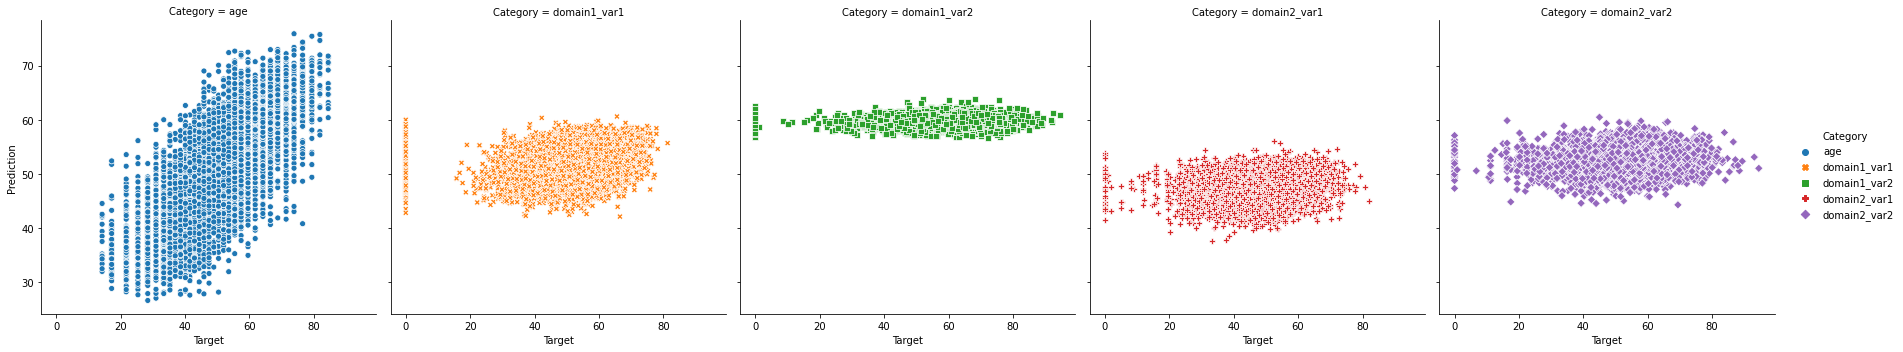

In [34]:
LOSS_WEIGHTS = [.3, .175, .175, .175, .175]

kf_split = 10
kf = StratifiedKFold(n_splits=kf_split, shuffle=True, random_state=2020)
y_oof = None
y_truth_oof = None
val_ids = []
gathered_preds = None
gathered_preds_flat = None

for i, (train_id, val_id) in enumerate(kf.split(train_df,y_data['bin_age_7'].values)):    
    print('Fold #:',i)
    data = prep_data(BS, val_id.tolist())
    learn = prep_learn(data, loss_base = 'MIX')

    lr = 4e-2
    reduceLR = callbacks.ReduceLROnPlateauCallback(learn=learn, monitor = 'valid_loss', mode = 'auto', patience = 2, factor = 0.2, min_delta = 0)
    learn.fit_one_cycle(10, lr, callbacks=[reduceLR])

    val_ids = val_ids+val_id.tolist()

    yv, yv_truth= learn.get_preds(ds_type=DatasetType.Valid)
    if y_oof == None:
        y_oof = yv
        y_truth_oof = yv_truth
    else:
        y_oof=torch.cat((y_oof,yv),0)
        y_truth_oof=torch.cat((y_truth_oof,yv_truth),0)
    
    g_preds, g_preds_flat = gather_preds(learn) #, ignore_vars=['age'])
    if isinstance(gathered_preds, pd.DataFrame):
        gathered_preds = gathered_preds.append(g_preds)
        gathered_preds_flat = gathered_preds_flat.append(g_preds_flat)
    else:
        gathered_preds = g_preds
        gathered_preds_flat = g_preds_flat


y_oof_1 = y_oof
y_truth_oof_1 = y_oof
val_ids_1 = val_ids
print(f'K-Fold:',kf_split)
print(f'Weighted normalized absolute error (Valid): {weighted_nae(y_oof,y_truth_oof)[-1]}')
for i, dv in enumerate(DEP_VAR):
    print(f'NAE {dv} (Valid): {weighted_nae(y_oof,y_truth_oof)[i]}')
plot_diff(y_oof, y_truth_oof)

gathered_preds_1 = gathered_preds
gathered_preds_flat_1 = gathered_preds_flat

make_submission(gathered_preds_1.sort_values('Id').reset_index(drop=True), filename = 'submission_10fold_MIX.csv')
make_submission(gathered_preds_flat_1.sort_values('Id').reset_index(drop=True), filename = 'mix_test_preds_out.csv')

In [35]:
train_preds_out = pd.DataFrame(y_oof_1.numpy(), index=val_ids_1).sort_index()
train_preds_out.columns = DEP_VAR
train_preds_out['Id'] = idx_train
train_preds_out.to_csv('mix_train_preds_out.csv', index = False)

train_preds_out1 = train_preds_out.copy()

train_preds_out1

,age,domain1_var1,domain1_var2,domain2_var1,domain2_var2,Id
0,61.543533,56.257244,59.753014,49.091408,51.840740,10001
1,56.579037,54.723026,57.811268,47.370773,52.576401,10002
2,49.751381,50.949474,60.404427,47.369274,50.474041,10004
3,61.349190,55.857792,58.221180,49.058483,53.177025,10005
4,46.617527,51.200401,58.904148,46.812401,52.573120,10007
...,...,...,...,...,...,...
5872,34.764336,46.408958,59.803539,44.065674,51.438053,21746
5873,49.666286,50.407925,58.841766,47.776665,54.548889,21747
5874,43.092499,49.120487,59.430111,48.111359,53.546833,21750
5875,56.036644,53.727486,58.529629,49.754642,54.488266,21752


### 10 fold MSE-loss + offset

Fold #: 0


epoch,train_loss,valid_loss,metric_idx,metric_idx,metric_idx,metric_idx,metric_idx,metric_total,time
0,0.030868,0.020049,0.254611,0.172443,0.143188,0.163240,0.150044,0.186443,00:01
1,0.022379,0.016929,0.224831,0.155313,0.130912,0.146222,0.125348,0.165064,00:01
2,0.018968,0.016107,0.241192,0.150750,0.118979,0.142540,0.142916,0.169515,00:01
3,0.017390,0.016151,0.231363,0.160034,0.121043,0.148183,0.130368,0.167344,00:01
4,0.016530,0.016501,0.235545,0.143261,0.132043,0.141499,0.140477,0.168187,00:01
5,0.016128,0.015690,0.234033,0.171944,0.122476,0.148459,0.129404,0.170359,00:01
6,0.015778,0.015723,0.234671,0.153956,0.123463,0.141583,0.136759,0.167660,00:01
7,0.015406,0.015659,0.235685,0.161134,0.124012,0.142014,0.135214,0.169121,00:01
8,0.015152,0.015658,0.232231,0.157642,0.124935,0.142107,0.135699,0.167737,00:01
9,0.014991,0.015608,0.230314,0.159076,0.123816,0.143698,0.134398,0.167267,00:01


Fold #: 1


epoch,train_loss,valid_loss,metric_idx,metric_idx,metric_idx,metric_idx,metric_idx,metric_total,time
0,0.030706,0.020936,0.223056,0.231915,0.155175,0.200082,0.239872,0.211649,00:01
1,0.022063,0.016968,0.203191,0.203115,0.119882,0.173830,0.205106,0.183796,00:01
2,0.018766,0.016278,0.202870,0.204049,0.119075,0.179845,0.194079,0.182844,00:01
3,0.017311,0.016164,0.188456,0.212439,0.115975,0.173525,0.174943,0.174991,00:01
4,0.016480,0.016011,0.200659,0.199563,0.132476,0.173510,0.194747,0.182749,00:01
5,0.016069,0.015960,0.202338,0.203555,0.126918,0.167723,0.186004,0.180437,00:01
6,0.015739,0.016008,0.200848,0.195228,0.132111,0.175750,0.179497,0.179707,00:01
7,0.015536,0.015969,0.201151,0.203316,0.128292,0.172764,0.175487,0.179321,00:01
8,0.015363,0.015603,0.198571,0.204643,0.123984,0.170283,0.181106,0.178574,00:01
9,0.015100,0.015653,0.200118,0.203283,0.125827,0.170491,0.180734,0.179094,00:01


Fold #: 2


epoch,train_loss,valid_loss,metric_idx,metric_idx,metric_idx,metric_idx,metric_idx,metric_total,time
0,0.029815,0.019791,0.189087,0.175897,0.201162,0.209584,0.252669,0.203606,00:01
1,0.022060,0.017005,0.170763,0.152451,0.148022,0.161726,0.231014,0.172541,00:01
2,0.018792,0.016352,0.154907,0.143781,0.146112,0.164841,0.241960,0.168394,00:01
3,0.017363,0.016051,0.159181,0.127351,0.146075,0.175101,0.234013,0.167199,00:01
4,0.016665,0.015872,0.156916,0.135039,0.143110,0.170122,0.232262,0.166168,00:01
5,0.016190,0.016147,0.160957,0.135792,0.143440,0.171392,0.227644,0.166984,00:01
6,0.015922,0.015636,0.151369,0.132915,0.141569,0.170292,0.231736,0.163800,00:01
7,0.015524,0.015608,0.151058,0.124439,0.145498,0.175212,0.229450,0.163372,00:01
8,0.015293,0.015575,0.154009,0.129124,0.139906,0.170443,0.231560,0.163633,00:01
9,0.015141,0.015554,0.151822,0.128404,0.141507,0.170828,0.229522,0.162842,00:01


Fold #: 3


epoch,train_loss,valid_loss,metric_idx,metric_idx,metric_idx,metric_idx,metric_idx,metric_total,time
0,0.033391,0.021484,0.211095,0.146965,0.184774,0.201805,0.169422,0.186347,00:01
1,0.022890,0.017199,0.200844,0.127803,0.164945,0.172048,0.166512,0.170732,00:01
2,0.019117,0.017280,0.202108,0.118432,0.158846,0.171154,0.177309,0.170137,00:01
3,0.017380,0.016505,0.195233,0.119255,0.151472,0.170071,0.159597,0.163639,00:01
4,0.016506,0.016515,0.193137,0.117559,0.149850,0.173698,0.165154,0.164037,00:01
5,0.016009,0.016226,0.187560,0.122260,0.159953,0.159500,0.164190,0.162301,00:01
6,0.015717,0.016112,0.188701,0.122223,0.157559,0.164789,0.165503,0.163373,00:01
7,0.015518,0.016190,0.190679,0.118695,0.152412,0.168083,0.163959,0.162755,00:01
8,0.015216,0.016022,0.187481,0.115890,0.159033,0.165268,0.165682,0.162272,00:01
9,0.015030,0.016026,0.186908,0.117611,0.159332,0.165291,0.165489,0.162424,00:01


Fold #: 4


epoch,train_loss,valid_loss,metric_idx,metric_idx,metric_idx,metric_idx,metric_idx,metric_total,time
0,0.030742,0.020745,0.137486,0.182862,0.151325,0.185694,0.207480,0.168534,00:01
1,0.022281,0.017207,0.130233,0.185785,0.138351,0.177073,0.163318,0.155362,00:01
2,0.018788,0.016551,0.131940,0.166866,0.140042,0.181084,0.155511,0.152195,00:01
3,0.017230,0.016224,0.137893,0.171779,0.128166,0.177165,0.163556,0.153485,00:01
4,0.016407,0.016386,0.140419,0.178360,0.140354,0.166652,0.157219,0.154578,00:01
5,0.015991,0.016492,0.142571,0.189980,0.141538,0.163179,0.155723,0.156595,00:01
6,0.015668,0.015882,0.145258,0.177352,0.136864,0.165476,0.149085,0.153613,00:01
7,0.015440,0.015969,0.141586,0.176964,0.137604,0.172654,0.153780,0.154651,00:01
8,0.015158,0.015879,0.146342,0.172039,0.139939,0.167374,0.145005,0.153165,00:01
9,0.014936,0.015872,0.146121,0.172511,0.139516,0.166941,0.144821,0.153000,00:01


Fold #: 5


epoch,train_loss,valid_loss,metric_idx,metric_idx,metric_idx,metric_idx,metric_idx,metric_total,time
0,0.031040,0.020354,0.172950,0.218551,0.239697,0.171010,0.177680,0.193099,00:01
1,0.022523,0.017251,0.157108,0.219685,0.202683,0.153269,0.148291,0.173820,00:01
2,0.018938,0.016819,0.164595,0.216241,0.192007,0.147958,0.136358,0.170577,00:01
3,0.017346,0.016826,0.177559,0.221717,0.180860,0.139031,0.160921,0.176210,00:01
4,0.016501,0.016580,0.155965,0.212040,0.181238,0.153598,0.151047,0.168926,00:01
5,0.015996,0.016520,0.161668,0.210345,0.186819,0.155987,0.159147,0.173152,00:01
6,0.015667,0.016191,0.169359,0.219213,0.175301,0.147178,0.145980,0.171150,00:01
7,0.015488,0.016146,0.163757,0.217541,0.173744,0.143291,0.156927,0.170140,00:01
8,0.015239,0.016029,0.163314,0.215201,0.169825,0.144277,0.150649,0.167986,00:01
9,0.015067,0.016008,0.165442,0.215003,0.168097,0.143015,0.151649,0.168241,00:01


Fold #: 6


epoch,train_loss,valid_loss,metric_idx,metric_idx,metric_idx,metric_idx,metric_idx,metric_total,time
0,0.032946,0.019904,0.166795,0.154314,0.114102,0.119004,0.221111,0.156531,00:01
1,0.023080,0.016913,0.161858,0.148773,0.140335,0.120344,0.182583,0.152164,00:01
2,0.019312,0.016338,0.147545,0.159097,0.131640,0.115026,0.195924,0.149559,00:01
3,0.017628,0.016087,0.144627,0.153437,0.143323,0.119943,0.192312,0.149966,00:01
4,0.016753,0.015842,0.147398,0.150501,0.138914,0.113193,0.197631,0.149261,00:01
5,0.016222,0.016596,0.158239,0.158613,0.148693,0.110795,0.186557,0.153287,00:01
6,0.015841,0.015732,0.146623,0.159659,0.148586,0.110709,0.196671,0.151721,00:01
7,0.015553,0.016101,0.153997,0.159402,0.149423,0.106422,0.193849,0.152791,00:01
8,0.015264,0.015654,0.152022,0.158556,0.148701,0.108581,0.202328,0.153786,00:01
9,0.015065,0.015630,0.152154,0.159423,0.149509,0.108071,0.198281,0.153321,00:01


Fold #: 7


epoch,train_loss,valid_loss,metric_idx,metric_idx,metric_idx,metric_idx,metric_idx,metric_total,time
0,0.029963,0.019197,0.222918,0.158703,0.150552,0.164835,0.167306,0.179120,00:01
1,0.021913,0.016164,0.216818,0.140812,0.159021,0.166357,0.147179,0.172385,00:01
2,0.018860,0.016175,0.211026,0.143335,0.165938,0.149732,0.150305,0.169937,00:01
3,0.017443,0.016281,0.215186,0.152400,0.173130,0.142659,0.153978,0.173435,00:01
4,0.016678,0.015747,0.208819,0.144405,0.158714,0.149177,0.163671,0.170440,00:01
5,0.016211,0.015940,0.211868,0.142246,0.166254,0.143772,0.158240,0.170400,00:01
6,0.015905,0.015553,0.210767,0.144732,0.160676,0.147251,0.151977,0.169041,00:01
7,0.015693,0.015427,0.208180,0.142326,0.163022,0.144846,0.151436,0.167739,00:01
8,0.015508,0.015541,0.207942,0.143036,0.163644,0.143878,0.164380,0.169997,00:01
9,0.015273,0.015399,0.207684,0.142851,0.165641,0.143699,0.161861,0.169764,00:01


Fold #: 8


epoch,train_loss,valid_loss,metric_idx,metric_idx,metric_idx,metric_idx,metric_idx,metric_total,time
0,0.035048,0.021323,0.188179,0.190796,0.182792,0.183289,0.182391,0.185826,00:01
1,0.023841,0.015389,0.157691,0.184161,0.152410,0.154736,0.147418,0.159084,00:01
2,0.019529,0.014596,0.162836,0.174840,0.147551,0.149063,0.135198,0.155015,00:01
3,0.017742,0.014493,0.152662,0.166316,0.148699,0.145164,0.131193,0.149289,00:01
4,0.016798,0.014670,0.140951,0.163412,0.142235,0.137326,0.132944,0.143071,00:01
5,0.016287,0.014568,0.148200,0.163507,0.149605,0.146312,0.139784,0.149322,00:01
6,0.015837,0.014409,0.153631,0.174756,0.148337,0.150922,0.138499,0.153279,00:01
7,0.015515,0.014287,0.156054,0.165200,0.147438,0.145644,0.137782,0.151128,00:01
8,0.015251,0.014303,0.149883,0.167221,0.148314,0.157205,0.134905,0.151303,00:01
9,0.015034,0.014329,0.149379,0.168339,0.150711,0.156929,0.135576,0.151836,00:01


Fold #: 9


epoch,train_loss,valid_loss,metric_idx,metric_idx,metric_idx,metric_idx,metric_idx,metric_total,time
0,0.031640,0.020230,0.270882,0.216662,0.167776,0.209695,0.204919,0.221099,00:01
1,0.022471,0.017608,0.249820,0.231737,0.163645,0.180374,0.197584,0.210281,00:01
2,0.018910,0.016215,0.248338,0.220241,0.168796,0.174211,0.186454,0.205699,00:01
3,0.017246,0.016079,0.250249,0.224091,0.161877,0.178169,0.182462,0.205730,00:01
4,0.016494,0.015608,0.238612,0.210062,0.163474,0.172629,0.181290,0.198888,00:01
5,0.016035,0.015719,0.245674,0.213413,0.166138,0.174631,0.180269,0.202231,00:01
6,0.015747,0.015528,0.243103,0.215758,0.158289,0.178902,0.183866,0.201874,00:01
7,0.015482,0.015684,0.244782,0.207881,0.161939,0.176306,0.189629,0.202192,00:01
8,0.015247,0.015426,0.241231,0.217930,0.165045,0.176007,0.187163,0.202945,00:01
9,0.014986,0.015433,0.243141,0.216015,0.163577,0.175925,0.186857,0.202858,00:01


K-Fold with offset: 10
Weighted normalized absolute error (Valid): 0.1588405817747116
NAE age (Valid): 0.14426882565021515
NAE domain1_var1 (Valid): 0.15137019753456116
NAE domain1_var2 (Valid): 0.15143704414367676
NAE domain2_var1 (Valid): 0.18123900890350342
NAE domain2_var2 (Valid): 0.17629623413085938
Shape of submission: (29385, 2)


,Id,Predicted
0,10003_age,60.735153
1,10003_domain1_var1,53.445797
2,10003_domain1_var2,59.635529
3,10003_domain2_var1,51.962990
4,10003_domain2_var2,53.445656
5,10006_age,64.721283
6,10006_domain1_var1,56.034496
7,10006_domain1_var2,59.360672
8,10006_domain2_var1,50.763313
9,10006_domain2_var2,52.019646


Shape of submission: (5877, 6)


,Id,age,domain1_var1,domain1_var2,domain2_var1,domain2_var2
0,10003,60.735153,53.445797,59.635529,51.962990,53.445656
1,10006,64.721283,56.034496,59.360672,50.763313,52.019646
2,10010,34.494576,47.629330,60.339848,44.066006,54.084690
3,10011,53.094219,51.841969,60.568001,50.596809,51.734447
4,10012,54.332863,54.600544,57.469997,47.251839,56.972057
5,10013,50.037807,51.107613,59.492619,48.771751,55.877048
6,10014,46.884651,51.390785,60.379318,47.039070,50.004723
7,10016,50.762619,52.203213,59.350700,47.629692,54.383987
8,10018,45.073631,50.357738,61.059025,47.315384,51.416584
9,10020,65.399323,56.002312,59.864548,51.366142,50.767242


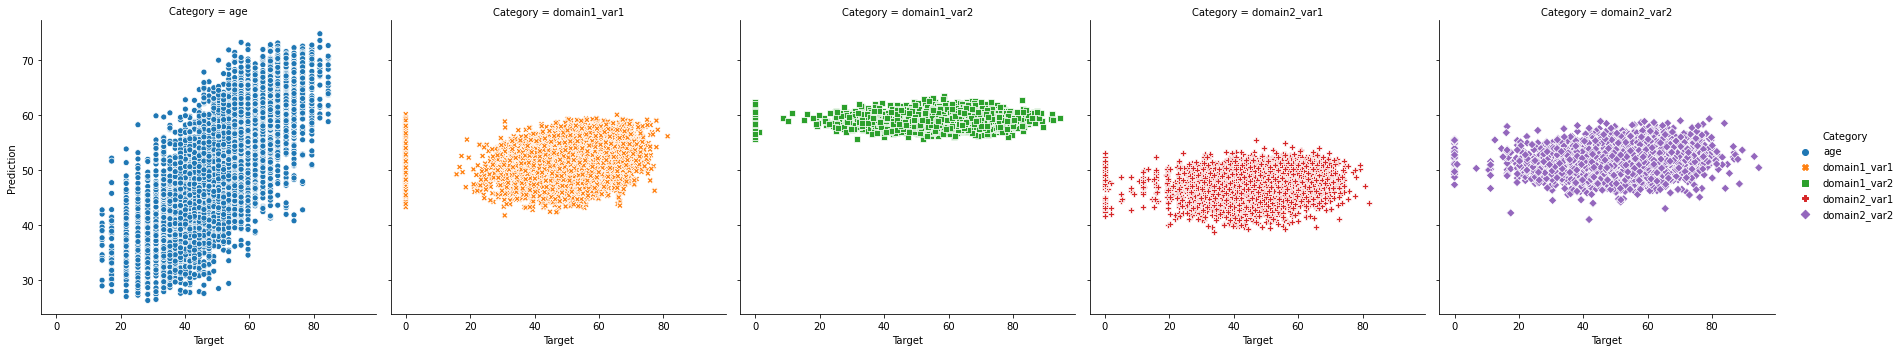

In [36]:
LOSS_WEIGHTS = [.3, .175, .175, .175, .175]

offset=torch.tensor([.3,.3,.8,.8,.8])

kf_split = 10
kf = StratifiedKFold(n_splits=kf_split, shuffle=True, random_state=2020)
y_oof = None
y_truth_oof = None
val_ids = []
gathered_preds = None
gathered_preds_flat = None

for i, (train_id, val_id) in enumerate(kf.split(train_df,y_data['bin_age_7'].values)):    #bin_age_7

    print('Fold #:',i)
    data = prep_data(BS, val_id.tolist())
    learn = prep_learn(data, loss_base = 'MSE')

    lr = 4e-2
    reduceLR = callbacks.ReduceLROnPlateauCallback(learn=learn, monitor = 'valid_loss', mode = 'auto', patience = 2, factor = 0.2, min_delta = 0)
    learn.fit_one_cycle(10, lr, callbacks=[reduceLR]) #MixUpCallback(learn, alpha=0.6),

    val_ids = val_ids+val_id.tolist()

    yv, yv_truth= learn.get_preds(ds_type=DatasetType.Valid)
    if y_oof == None:
        y_oof = yv
        y_truth_oof = yv_truth
    else:
        y_oof=torch.cat((y_oof,yv),0)
        y_truth_oof=torch.cat((y_truth_oof,yv_truth),0)
    
    g_preds, g_preds_flat = gather_preds(learn, offset = offset) #, ignore_vars = ['domain1_var1','domain1_var2', 'domain2_var1', 'domain2_var2'])
    if isinstance(gathered_preds, pd.DataFrame):
        gathered_preds_flat = gathered_preds_flat.append(g_preds_flat)
        gathered_preds = gathered_preds.append(g_preds)
    else:
        gathered_preds = g_preds
        gathered_preds_flat = g_preds_flat

        
y_oof_2 = y_oof
y_truth_oof_2 = y_oof
val_ids_2 = val_ids
print(f'K-Fold with offset:',kf_split)
print(f'Weighted normalized absolute error (Valid): {weighted_nae(y_oof,y_truth_oof)[-1]}')
for i, dv in enumerate(DEP_VAR):
    print(f'NAE {dv} (Valid): {weighted_nae(y_oof,y_truth_oof)[i]}')
plot_diff(y_oof, y_truth_oof)


gathered_preds_2 = gathered_preds
gathered_preds_flat_2 = gathered_preds_flat

make_submission(gathered_preds_2.sort_values('Id').reset_index(drop=True), filename = 'submission_10fold_MSE_offset.csv')
make_submission(gathered_preds_flat_2.sort_values('Id').reset_index(drop=True), filename = 'mse_test_preds_out.csv')

In [37]:
train_preds_out = pd.DataFrame(y_oof_2.numpy(), index=val_ids_2).sort_index()
train_preds_out.columns = DEP_VAR
train_preds_out['Id'] = idx_train
train_preds_out.to_csv('mse_train_preds_out.csv', index = False)

train_preds_out2 = train_preds_out.copy()

train_preds_out2

,age,domain1_var1,domain1_var2,domain2_var1,domain2_var2,Id
0,62.288288,55.034161,58.657200,49.881561,51.123966,10001
1,55.451801,54.512466,58.415573,46.974926,50.081123,10002
2,50.430290,52.106823,60.062950,46.119553,49.117264,10004
3,60.580353,54.303036,58.733063,50.226028,51.466274,10005
4,44.681629,50.050171,58.879780,46.896412,53.163605,10007
...,...,...,...,...,...,...
5872,33.981750,46.061718,60.654129,44.639450,51.311428,21746
5873,49.926472,50.146027,58.961876,47.813080,53.283203,21747
5874,42.146004,49.276184,59.436375,46.508362,52.424675,21750
5875,57.848145,54.067211,58.927135,47.858318,50.673897,21752


### Best of blended

In [38]:
gathered_preds_flat_1

,Id,age,domain1_var1,domain1_var2,domain2_var1,domain2_var2
0,10003,61.866253,55.356903,58.921135,51.763714,55.586365
1,10006,67.242119,57.536758,60.571873,52.676132,51.698143
2,10010,37.592365,48.708515,61.114735,45.125160,53.986080
3,10011,55.741100,53.596191,61.220230,50.545334,50.682060
4,10012,53.159172,54.789249,58.907368,47.818420,57.310398
...,...,...,...,...,...,...
5872,21745,40.498909,50.789185,60.591896,45.446667,55.552025
5873,21748,50.268307,53.764294,60.837364,47.414276,54.604679
5874,21749,39.419983,48.931911,61.706554,45.750481,52.267155
5875,21751,39.547493,50.826618,59.192421,44.284477,58.470726


K-Fold blended
Weighted normalized absolute error (Valid): 0.15833181142807007
NAE age (Valid): 0.14363576471805573
NAE domain1_var1 (Valid): 0.15117289125919342
NAE domain1_var2 (Valid): 0.15099655091762543
NAE domain2_var1 (Valid): 0.1807415634393692
NAE domain2_var2 (Valid): 0.1756094992160797
Shape of submission: (29385, 2)


,Id,Predicted
0,10003_age,61.426999
1,10003_domain1_var1,54.493941
2,10003_domain1_var2,60.028071
3,10003_domain2_var1,52.124485
4,10003_domain2_var2,54.631952
5,10006_age,65.891947
6,10006_domain1_var1,57.027909
7,10006_domain1_var2,60.159825
8,10006_domain2_var1,51.334336
9,10006_domain2_var2,52.422235


Shape of submission: (5877, 6)


,Id,age,domain1_var1,domain1_var2,domain2_var1,domain2_var2
0,10003,61.426999,54.493941,60.028071,52.124485,54.631952
1,10006,65.891947,57.027909,60.159825,51.334336,52.422235
2,10010,35.773416,48.246576,60.978831,44.885277,54.565719
3,10011,53.607938,52.813050,61.064919,50.842513,52.445992
4,10012,55.000499,55.155507,58.257042,48.112453,57.497591
5,10013,51.009282,52.287148,60.195604,48.809428,56.262488
6,10014,47.595584,51.847463,61.057070,47.917260,50.754521
7,10016,51.134518,53.005798,60.099737,47.876256,55.098569
8,10018,45.524251,51.144012,61.523391,47.699310,52.159798
9,10020,65.982080,56.750947,60.602005,51.883537,51.136079


Shape of submission: (5877, 6)


,Id,age,domain1_var1,domain1_var2,domain2_var1,domain2_var2
0,10001,61.543533,56.257244,59.753014,49.091408,51.840740
1,10002,56.579037,54.723026,57.811268,47.370773,52.576401
2,10004,49.751381,50.949474,60.404427,47.369274,50.474041
3,10005,61.349190,55.857792,58.221180,49.058483,53.177025
4,10007,46.617527,51.200401,58.904148,46.812401,52.573120
5,10008,47.926704,49.155521,60.117805,49.360111,50.384037
6,10009,57.052414,51.943863,60.618031,51.300980,49.108505
7,10015,63.111511,54.988697,59.806530,51.386078,50.771641
8,10017,41.753437,49.887478,58.795570,45.346424,54.811592
9,10019,32.100143,45.248676,59.665573,44.360023,53.323452


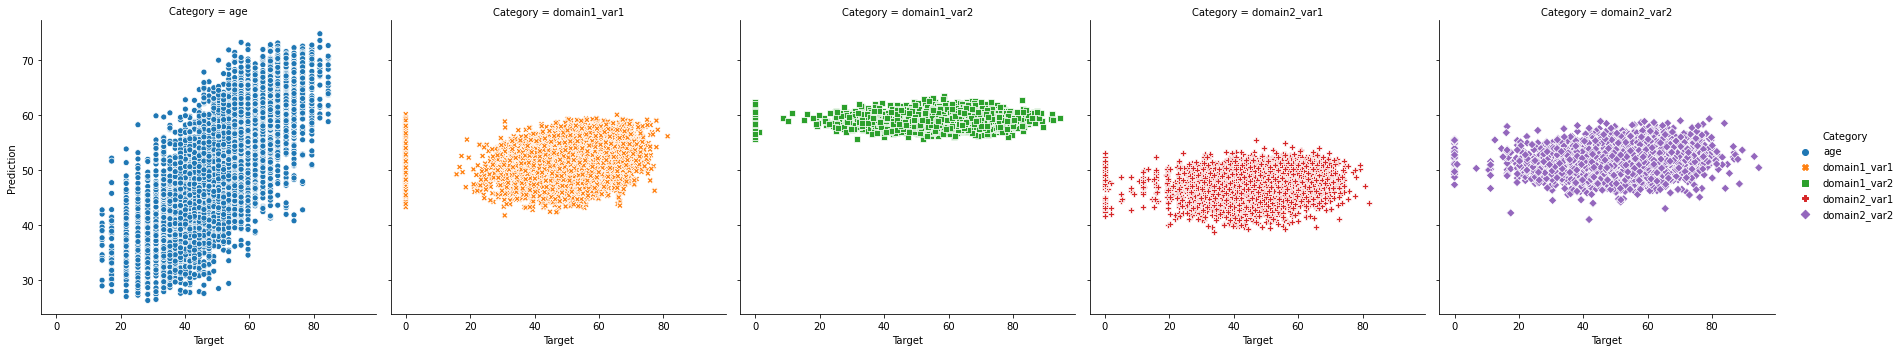

In [39]:
offset = tensor([.3,.3,.3,.3,.3])

print(f'K-Fold blended')
print(f'Weighted normalized absolute error (Valid): {weighted_nae((y_oof_1 + y_oof_2)/2 + offset, y_truth_oof)[-1]}')
for i, dv in enumerate(DEP_VAR):
    print(f'NAE {dv} (Valid): {weighted_nae((y_oof_1 + y_oof_2)/2 + offset, y_truth_oof)[i]}')
plot_diff(y_oof, y_truth_oof)

# offset
gp1 = gathered_preds_1.copy()
gp2 = gathered_preds_2.copy()
gp1['Predicted']=gathered_preds_1['Predicted']+.3
gp2['Predicted']=gathered_preds_2['Predicted']+.3

gp_flat1 = gathered_preds_flat_1.copy()
gp_flat2 = gathered_preds_flat_2.copy()
for dv in DEP_VAR:
    gp_flat1[dv]=gathered_preds_flat_1[dv]+.3
    gp_flat2[dv]=gathered_preds_flat_2[dv]+.3

make_submission(gp1.append(gp2).sort_values('Id').reset_index(drop=True), filename = 'submission_10kfold_blended.csv')

make_submission(gp_flat1.append(gp_flat2).sort_values('Id').reset_index(drop=True), filename = 'blended_test_preds_out.csv')
make_submission(train_preds_out1.append(train_preds_out1).sort_values('Id').reset_index(drop=True), filename = 'blended_train_preds_out.csv')
